In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import myCROCOtools as croco
from   xgcm import Grid
import xrft                     # modified package to include stochasticity in xrft.ifft
from datetime import datetime
import pandas as pd

In [2]:
#-- directories --
dir_in  = '/home2/datawork/qjamet/CROCO_Inria/RUNS/CONVECTION'
dir_fig = '/home2/datahome/qjamet/Figures/CONVECTION'

#-- load data (NBQ with KPP) --
# NOTE: reconstruction does not work with avg outputs because AKt is not outputed correctly (don't know why ...)
ds = xr.open_dataset("%s/run_NBQ_TS_VADV_C2_LMD_MIXING/convec_his.nc" % (dir_in))
#ds = xr.open_dataset("%s/run_0001g_TS_VADV_C2/convec_his.nc" % (dir_in))y
#ds = xr.open_dataset("%s/run_0001i/convec_his.nc" % (dir_in))
#- vertical and horizontal mesh -
ds = croco.grid_z(ds, tvar=False)
ds = croco.grid_hz(ds, vertical=True)
# 1d vertical mesh
ds['z_rho_1d'] = ds.z_rho.mean(dim=['eta_rho', 'xi_rho'])
ds['z_w_1d'] = ds.z_w.mean(dim=['eta_rho', 'xi_rho'])
ds['dz_rho_1d'] = ds.dz_rho.mean(dim=['eta_rho', 'xi_rho'])
ds['dz_w_1d'] = ds.dz_w.mean(dim=['eta_rho', 'xi_rho'])

#-- Some parameters --
dt_model=2.5                          # model time step [sec]
nwrt=240                              # freq of outputs (nwrt*dt=600sec=10min)
alphaT = 2.e-4                        # [K^{-1}]-- from croco.in
Cp     = 3985.                        # [J K^{-1} kg^{-1}] -- from scalar.h
g      = 9.81                         # [m/s2]  -- from croco
rho0   = 1000.0 + (ds.rho[0, ...]*ds.dx_rho*ds.dy_rho*ds.dz_rho).sum() \
                  /(ds.dx_rho*ds.dy_rho*ds.dz_rho).sum()
qnet   = 500                          # [W/m^2] -- atmo convention, +=up
wT0    = qnet/(rho0*Cp)               # surface boundary conditions for temperature
wb0    = (g*alphaT*qnet)/(rho0*Cp)    # surface boundary conditions for buoyancy
strat  = 1.9620001275490499e-6        # Initial stratification 
iit00 = 360                           # Snapshot iter (60 hours) -- 240 -> 40hrs

#-- compute buoyancy --
ds['bbb'] = -(ds.rho+1000 - rho0)*g / rho0
#ds['bbb_r'] = (ds.bbb-ds.bbb[0, ...])

#-- time filtered outputs --
Nint  = 18                     # Nint=18 -> 3 hours == decorrelation timescale ; used to apply time filtering
ds_tm = ds.coarsen(time=Nint, boundary='trim').mean()

#-- compute temperature vertical fluxes --
ds = croco.wb(ds, tracer='T', sbcs=500, full=True)
ds_tm = croco.wb(ds_tm, tracer='T', sbcs=500, full=True)

#-- compute mixed layer depth --
croco.mld(ds, strat=strat)

#####################
#- define xgcm grid -
if 'CPP-options' in ds.attrs:
    cpp = 'CPP-options'
else:
    cpp = 'CPPS'
#
coords_xy={'x':{'center':'xi_rho',  'left':'xi_u'},
      'y':{'center':'eta_rho', 'left':'eta_v'}}
coords_z={'z':{'center':'s_rho',   'outer':'s_w'}}
grid_xy = Grid(ds,
     coords=coords_xy,
     periodic=True)
grid_z = Grid(ds,
     coords=coords_z,
     periodic=False)
#####################

#
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

-- Compute vertical mesh at rest --
-- Add horizontal metric --
         are removed since xgcm handles boundary conditions accuratly in this case.
Data array is 3D
-- Add dx/dy --
- add vertical metrics for u, v, rho and psi points
-- Add rA --
-- compute TEMPERATURE vertical flux --
-->> Resolved fluxes
-->> Sub-grid scale fluxes based on AKt in ds ; apply boundary conditions given by sbcs
-- compute TEMPERATURE vertical flux --
-->> Resolved fluxes
-->> Sub-grid scale fluxes based on AKt in ds ; apply boundary conditions given by sbcs
---- DONE ---- for time:  432 / 433


'2025-06-13 13:41:37'

#### Compute decorrelation time for $\Omega$

In [17]:
croco.mld(ds, strat=1.9620001275490499e-6);
tmpw = ds.omega.stack(xy=("eta_rho", "xi_rho"))
tmpk = ds.kmld+((ds.dims['s_w']-ds.kmld)/2)
Twind  = 40
tmp1=(((tmpw[iit00, ...]*tmpw[iit00:iit00+Twind, ...])).mean(dim=['xy']))/ \
        (tmpw[iit00, ...].std(dim='xy', ddof=1)*tmpw[iit00:iit00+Twind, ...].std(dim='xy', ddof=1))
# iit00=231
# Twind  = 60
# tmp2=(((tmpw[iit00, ...]*tmpw[iit00:iit00+Twind, ...])).mean(dim=['xy']))/ \
#         (tmpw[iit00, ...].std(dim='xy', ddof=1)*tmpw[iit00:iit00+Twind, ...].std(dim='xy', ddof=1))

In [4]:
# theoritical deccorelation timescale
maxvarw = tmpw.std(dim='xy', ddof=1).max(dim='s_w')
t_decorr_theo = -ds.mld/maxvarw
#
t_decorr = xr.zeros_like(ds.time)
Twind  = 40
#
for iit0 in range(1, ds.dims['time']):
    print('-- time', iit0, '/', ds.dims['time'], end='\r')
    tmp=(((tmpw[iit0, ...]*tmpw[iit0:iit0+Twind, ...])).mean(dim=['xy']))/ \
         (tmpw[iit0, ...].std(dim='xy', ddof=1)*tmpw[iit0:iit0+Twind, ...].std(dim='xy', ddof=1))
    test=np.where(tmp[int(tmpk[iit0]), :] < 0.2)[0]
    if not test.size > 0 :
        print('--- STOP ---')
        break
    else:
        idecorr = test[0]
        t_decorr[iit0] = (ds.time[iit0+idecorr]-ds.time[iit0])/3600
#
ds['t_decorr'] = t_decorr.where(t_decorr != 0.0)

--- STOP ---/ 433


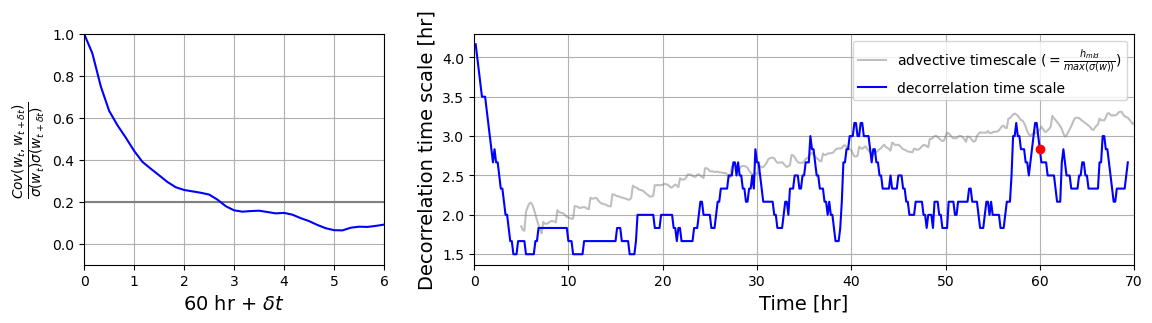

In [5]:
# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

saveF=False
#
fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)
#
ax[0].plot(np.arange(Twind)*10*60/3600, 0.2*np.ones(Twind), 'gray')
ax[0].plot(np.arange(Twind)*10*60/3600, tmp1[int(tmpk[iit00])], 'b')
ax[0].set_position([0.125, 0.11, 0.25, 0.77])
ax[0].set(xlim=[0, 6], ylim=[-.1, 1.0], xlabel=str(r"%i hr + $\delta t$" % (ds.time[iit00].data/3600) ), \
          ylabel=r"$\frac{Cov(w_t, w_{t+\delta t})}{\sigma(w_t)\sigma(w_{t+\delta t})}$")
ax[0].grid()
#
ax[1].plot(ds.time[30:]/3600, t_decorr_theo[30: ]/3600, 'gray', alpha=0.5, label=r"advective timescale ($=\frac{h_{mld}}{max(\sigma(w))}$)")
ax[1].plot(ds.time/3600, ds.t_decorr, 'b', label='decorrelation time scale')#, ':', lw=3)
ax[1].legend()
ax[1].plot(ds.time[iit00]/3600, ds.t_decorr[iit00], 'ro')
ax[1].set_position([0.45, 0.11, 0.55, 0.77])
plt.grid()
ax[1].set(xlabel='Time [hr]', ylabel='Decorrelation time scale [hr]', xlim=[0, 70])
#
if saveF:
    figN = "w_NBQ_decorrelation_time_scale_fcn_of_time"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

#### Compute horizontally averaged T and vertical wb fluxes

In [3]:
#-------------------------------
# For original, 10-min snapshots
#-------------------------------
ds2 = xr.Dataset(
    data_vars=dict(
        temp=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        u=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        v=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        bbb=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        bbb_w=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        Tz=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        bz=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        Tz2=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        Tz3=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        sigzT=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        wmTm=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        dz_rho=(["s_rho"], ds.dz_rho.mean(dim=['eta_rho','xi_rho']).data),
        dz_w=(["s_w"], ds.dz_w.mean(dim=['eta_rho','xi_rho']).data),
        axx=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        ayy=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        azz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        axy=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        axz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        ayz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        dSigTdz=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        dSigP2dz=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        dSigbdz=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        At=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        Au=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        Ag=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
        Pt=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        Psig=(["time", "s_rho"], np.zeros([ds.dims['time'], ds.dims['s_rho']])),
    ),
    coords=dict(
        s_rho=ds.s_rho,
        s_w=ds.s_w,
        time=ds.time,
    ),
    attrs=dict(description="Horizontally averaged quantities"),
)

#
#for iit in range(ds.dims['time']):
#print('-- time', it, '/', ds.dims['time'], end='\r')
#- temperature -
ds2["temp"] = ds.temp.mean(dim=['eta_rho','xi_rho'])
#- u -
ds2["u"] = ds.u.mean(dim=['eta_rho','xi_u'])
#- v -
ds2["v"] = ds.v.mean(dim=['eta_v','xi_rho'])
#- buoyancy -
ds2["bbb"] = ds.bbb.mean(dim=['eta_rho','xi_rho'])
#- based on hz avg w and T -
ds2["wmTm"] = ds.omega.mean(dim=['eta_rho', 'xi_rho']) \
     *grid_z.interp(ds.temp.mean(dim=['eta_rho', 'xi_rho']), 'z', boundary='extrapolate')
#ds2.wmTm = 0.0
    
#- resolved and sgs wT -
#tmp = croco.wb(ds, tracer='T', sbcs=500, full=False)
#ds2['wT'] = tmp.wT
#ds2['wT_sgs'] = tmp.wT_sgs
ds2['wT'] = ds.wT.mean(dim=['eta_rho', 'xi_rho'])
ds2['wT_sgs'] = ds.wT_sgs.mean(dim=['eta_rho', 'xi_rho'])
#- resovled and sgs wb -
tmp = croco.wb(ds, tracer='b', sbcs=500, full=False)
ds2['wb'] = tmp.wb
ds2['wb_sgs'] = tmp.wb_sgs

#-- vertical derivatives or interpolation --
ds2['dTdz'] = grid_z.diff(ds2.temp, 'z', boundary='extrapolate')/ds2.dz_w
ds2.dTdz[:, 0] = ds2.dTdz[:, 1]
ds2.dTdz[:, -1] = ds2.dTdz[:, -2]
#
# ds2['bbb_w']=grid_z.interp(ds2.bbb,'z', boundary='extrapolate')
# ds2.bbb_w[:, -1]=ds2.bbb_w[:, -2]
# ds2.bbb_w[:, 0]=ds2.bbb_w[:, 1]
#

#-- temperature variance --
ds2['Tvar'] = ds.temp.stack(xy=('eta_rho', 'xi_rho')).var(dim='xy', ddof=1)

#- some metrics -
ds2['z_rho'] = ds.z_rho.mean(dim=['eta_rho','xi_rho'])
ds2['z_w'] = ds.z_w.mean(dim=['eta_rho','xi_rho'])


#-------------------
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

-- compute BUOYANCY vertical flux --
-- based on linear, temperature driven EOS --
-->> Resolved fluxes
-->> Sub-grid scale fluxes based on AKt in ds ; apply boundary conditions given by sbcs
---- DONE ----


'2025-06-13 13:45:29'

In [4]:
#-----------------------
# For time filtered data
#-----------------------
ds2_tm = xr.Dataset(
    data_vars=dict(
        temp=(["time", "s_rho"], np.zeros([ds_tm.dims['time'], ds_tm.dims['s_rho']])),
        Tz=(["time", "s_rho"], np.zeros([ds_tm.dims['time'], ds_tm.dims['s_rho']])),
        dz_rho=(["s_rho"], ds_tm.dz_rho.mean(dim=['eta_rho','xi_rho']).data),
    ),
    coords=dict(
        s_rho=ds_tm.s_rho,
        s_w=ds_tm.s_w,
        time=ds_tm.time,
    ),
    attrs=dict(description="Horizontally averaged quantities -- 3-hourly averaged data"),
)

#- temperature -
ds2_tm["temp"] = ds_tm.temp.mean(dim=['eta_rho','xi_rho'])
#- resolved and sgs wT -
ds2_tm['wT'] = ds_tm.wT.mean(dim=['eta_rho', 'xi_rho'])
ds2_tm['wT_sgs'] = ds_tm.wT_sgs.mean(dim=['eta_rho', 'xi_rho'])
ds2_tm['wT_sgs2'] = ds2.wT_sgs.coarsen(time=Nint, boundary='trim').mean()

#- some metrics -
ds2_tm['z_rho'] = ds_tm.z_rho.mean(dim=['eta_rho','xi_rho'])
ds2_tm['z_w'] = ds_tm.z_w.mean(dim=['eta_rho','xi_rho'])

#-------------------
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

---- DONE ----


'2025-06-13 13:45:29'

# Deterministic offline forced first-order model for hz averaged T

Compute $\overline{T}^{n+1}=\overline{T}^n - \Delta t \left( \partial_z \overline{w}\overline{T}+\partial_z \overline{w'T'} - \overline{Q}\right)$

with $\overline{X}=\frac{1}{A}\int_{xy} X~dxdy$

and $\overline{w'T'}=\overline{w'T'_{res.}}+\overline{w'T'_{sgs}}$

Note: Practically, $Q$ is set as surface boundary condition for sub-grid-scale vertical buoyancy fluxes $\overline{w'T'_{sgs}}$

Note2: USE $\Omega$ (S-coordinate vertical momentum component) for vertical velocities !!!

#### Offline forced first-order model

In [5]:
istart=1
#
ds2.Tz[istart-1, :] = ds2.temp[istart-1, :]
ds2.bz[istart-1, :] = ds2.bbb[istart-1, :]
for iit in range(istart, ds.dims['time']):
    print('-- time', iit, '/', ds.dims['time'], end='\r')
    #- based on snapshots -
    ds2.Tz[iit, :] = ds2.Tz[iit-1, :] - dt_model*nwrt * grid_z.diff( (ds2.wT[iit-1, :]+ds2.wT_sgs[iit-1, :]),'z')/ds2.dz_rho 
#     ds2.Tz[iit, :] = ds2.Tz[iit-1, :] - 0.5*dt_model*nwrt*( grid_z.diff( (ds2.wT[iit-1, :]+ds2.wT_sgs[iit-1, :]),'z')/ds2.dz_rho \
#                                                      +grid_z.diff( (ds2.wT[iit  , :]+ds2.wT_sgs[iit  , :]),'z')/ds2.dz_rho)
#     ds2.bz[iit, :] = ds2.bz[iit-1, :] - 0.5*dt_model*nwrt*( grid_z.diff( (ds2.wb[iit-1, :]+ds2.wb_sgs[iit-1, :]),'z')/ds2.dz_rho \
#                                                      +grid_z.diff( (ds2.wb[iit  , :]+ds2.wb_sgs[iit  , :]),'z')/ds2.dz_rho)
#
ds2.Tz2[istart-1, :] = ds2.temp[istart-1, :]
for iit in range(istart, ds.dims['time']):
    print('-- time', iit, '/', ds.dims['time'], end='\r')
    #- based on snapshots -
    ds2.Tz2[iit, :] = ds2.Tz2[iit-1, :] - 0.5*dt_model*nwrt*( grid_z.diff( (ds2.wmTm[iit-1, :]),'z')/ds2.dz_rho \
                                                       +grid_z.diff( (ds2.wmTm[iit  , :]),'z')/ds2.dz_rho)

#
# For time filtered data
#
ds2_tm.Tz[istart-1, :] = ds2_tm.temp[istart-1, :]
for iit in range(istart, ds_tm.dims['time']):
    print('-- time', iit, '/', ds_tm.dims['time'], end='\r')
    #- based on snapshots -
    ds2_tm.Tz[iit, :] = ds2_tm.Tz[iit-1, :] - dt_model*nwrt*Nint * grid_z.diff( (ds2_tm.wT[iit-1, :]+ds2_tm.wT_sgs2[iit-1, :]),'z')/ds2_tm.dz_rho 

#### Plot

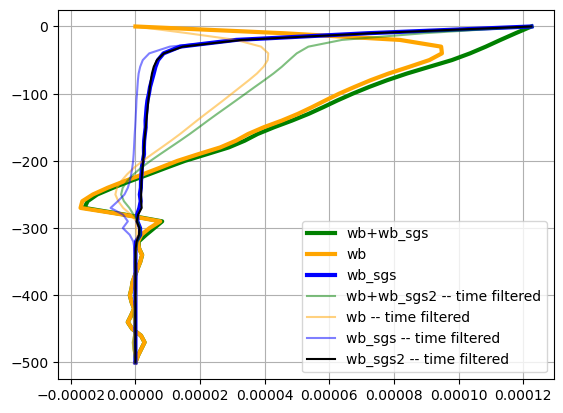

In [11]:
iit=iit00
plt.figure()
#plt.plot(ds2.wT[iit, :], ds2.z_w, label='wT')
plt.plot(ds2.wT[iit, :]+ds2.wT_sgs[iit, :], ds2.z_w, label='wb+wb_sgs', color='green', lw=3)
plt.plot(ds2.wT[iit, :], ds2.z_w, label='wb', color='orange', lw=3)
plt.plot(ds2.wT_sgs[iit, :], ds2.z_w, label='wb_sgs', color='blue', lw=3)
plt.plot(ds2_tm.wT[int(iit/Nint), :]+ds2_tm.wT_sgs2[int(iit/Nint), :], ds2_tm.z_w, label='wb+wb_sgs2 -- time filtered', alpha =0.5, color='green')
plt.plot(ds2_tm.wT[int(iit/Nint), :], ds2_tm.z_w, label='wb -- time filtered', alpha =0.5, color='orange')
plt.plot(ds2_tm.wT_sgs[int(iit/Nint), :], ds2_tm.z_w, label='wb_sgs -- time filtered', alpha =0.5, color='blue')
plt.plot(ds2_tm.wT_sgs2[int(iit/Nint), :], ds2_tm.z_w, label='wb_sgs2 -- time filtered', color='k')
plt.grid()
plt.legend()

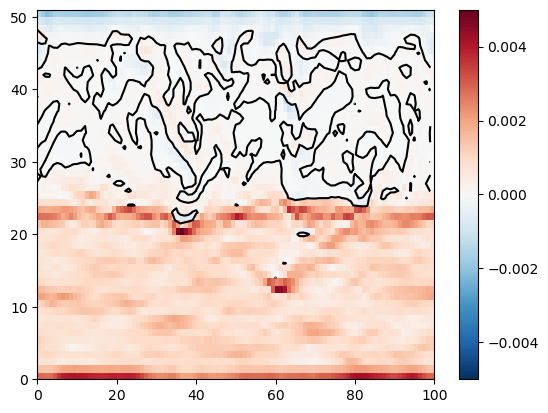

In [38]:
plt.pcolor( (grid_z.diff(ds.temp.isel(time=int(iit00)), 'z', boundary='extrapolate')/ds.dz_w).isel(eta_rho=50), vmin=-0.005, vmax=0.005, cmap='RdBu_r' )
plt.colorbar()
plt.contour( (grid_z.diff(ds.temp.isel(time=int(iit00)), 'z', boundary='extrapolate')/ds.dz_w).isel(eta_rho=50), levels=[0], colors='k' )

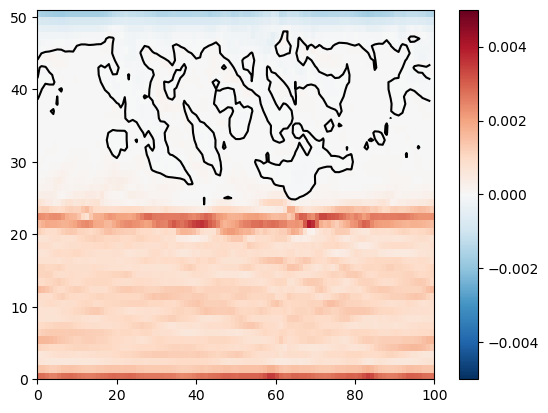

In [39]:
plt.pcolor( (grid_z.diff(ds_tm.temp.isel(time=int(iit00/Nint)), 'z', boundary='extrapolate')/ds_tm.dz_w).isel(eta_rho=50), vmin=-0.005, vmax=0.005, cmap='RdBu_r' )
plt.colorbar()
plt.contour( (grid_z.diff(ds_tm.temp.isel(time=int(iit00/Nint)), 'z', boundary='extrapolate')/ds_tm.dz_w).isel(eta_rho=50), levels=[0], colors='k' )

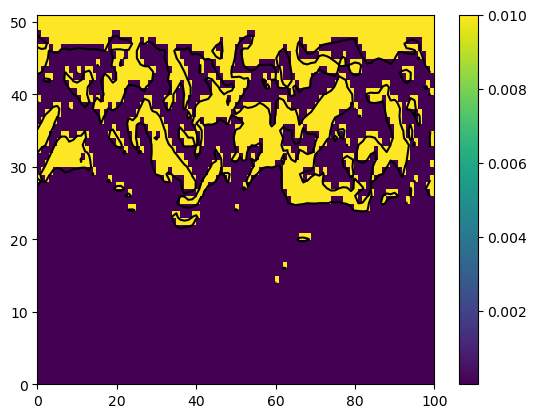

In [48]:
plt.pcolor( ds.AKt.isel(time=iit00, eta_rho=50), vmin=1e-5, vmax=0.01)
plt.colorbar()
plt.contour( (grid_z.diff(ds.temp.isel(time=int(iit00)), 'z', boundary='extrapolate')/ds.dz_w).isel(eta_rho=50), levels=[0], colors='k' )

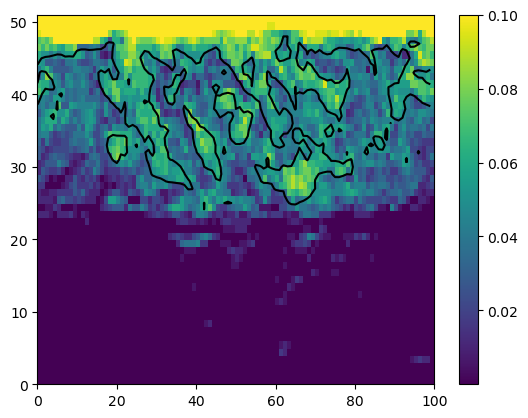

In [49]:
plt.pcolor( ds_tm.AKt.isel(time=int(iit00/Nint), eta_rho=50), vmin=1e-5, vmax=0.1)
plt.colorbar()
plt.contour( (grid_z.diff(ds_tm.temp.isel(time=int(iit00/Nint)), 'z', boundary='extrapolate')/ds_tm.dz_w).isel(eta_rho=50), levels=[0], colors='k' )

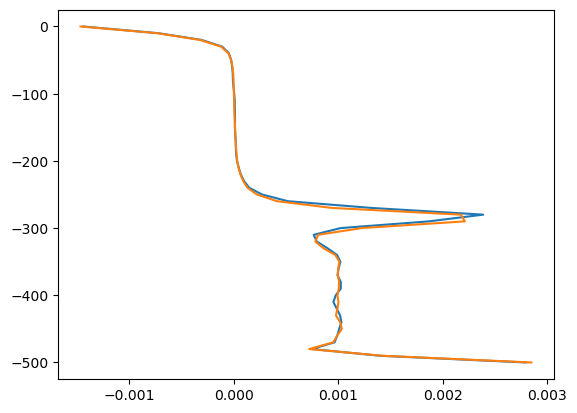

In [29]:
plt.plot((grid_z.diff(ds.temp.isel(time=int(iit00)), 'z', boundary='extrapolate')/ds.dz_w).mean(dim=['eta_rho', 'xi_rho']), ds.z_w_1d)
plt.plot((grid_z.diff(ds_tm.temp.isel(time=int(iit00/Nint)), 'z', boundary='extrapolate')/ds_tm.dz_w_1d).mean(dim=['eta_rho', 'xi_rho']), ds.z_w_1d)
#plt.plot(ds_tm.AKt.isel(time=int(iit00/Nint)).mean(dim=['eta_rho', 'xi_rho']), ds_tm.z_w_1d)

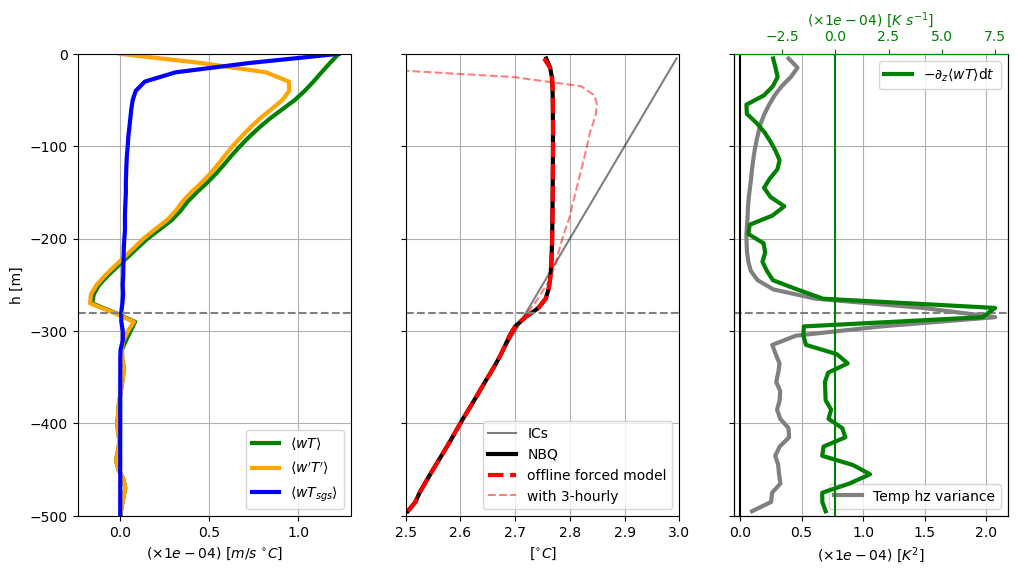

In [9]:
saveF=True
iit = iit00
kmld = 22
scaleF=1e4
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=3)
#
ax[0].plot((ds2.wT[iit, :]+ds2.wT_sgs[iit, :])*scaleF,ds2.z_w, color='green', label=r"$\left< wT \right>$", lw=3)
ax[0].plot(ds2.wT[iit, :]*scaleF,ds2.z_w, color='orange', label=r"$\left< w'T' \right>$", lw=3)
ax[0].plot(ds2.wT_sgs[iit, :]*scaleF,ds2.z_w, color='blue', label=r"$\left< wT_{sgs} \right>$", lw=3)
#ax[0].plot(ds2.wmTm[iit, :]*scaleF,ds2.z_w, 'b--', alpha=0.5, label=r'$\overline{w}\overline{T}$')
ax[0].set(ylabel=r'h [m]', \
          xlabel=str(r'$(\times %.00e)~[m/s~^{\circ}C]$' % (1/scaleF)), ylim=[ds2.z_w.min(), 0.0])
ax[0].legend(loc='lower right')
ax[0].grid()
ax[0].axhline(y=ds.mld.isel(time=iit), color='gray', linestyle='--')
#
ax[1].plot(ds2.temp[0, :], ds2.z_rho, 'k',alpha=0.5, label='ICs')
ax[1].plot(ds2.temp[iit, :], ds2.z_rho, 'k', label='NBQ', lw=3)
ax[1].plot(ds2.Tz[iit,:],ds2.z_rho, 'r--', lw=3, label='offline forced model')
ax[1].plot(ds2_tm.Tz[int(iit/Nint),:],ds2_tm.z_rho, 'r--', label='with 3-hourly', alpha=0.5)
#ax[1].plot(ds2.Tz2[iit,:],ds2.s_rho, 'b--', alpha=0.5, label='zeroth-order with $\overline{w}\overline{T}$')
ax[1].set(yticklabels=[], xlabel=r'[$^{\circ}C$]', ylim=[ds2.z_w.min(), 0.0], xlim=[2.5, 3.0])
ax[1].legend(loc='lower right')
ax[1].grid()
ax[1].axhline(y=ds.mld.isel(time=iit), color='gray', linestyle='--')
#
ax[2].plot(ds2.Tvar[iit, :]*scaleF, ds2.z_rho, 'gray', lw=3, label='Temp hz variance')
ax[2].set(yticklabels=[], xlabel=str(r'$(\times %.00e)~[K^2]$' % (1/scaleF)), \
          ylim=[ds2.z_w.min(), 0.0])
ax[2].legend(loc='lower right')
ax[2].grid()
ax[2].axhline(y=ds.mld.isel(time=iit), color='gray', linestyle='--')
ax[2].axvline(x=0, color='k')
ax2 = ax[2].twiny()
ax2.plot(-scaleF*grid_z.diff(ds2.wT.isel(time=iit)+ds2.wT_sgs.isel(time=iit),'z')/ds2.dz_rho * dt_model*nwrt, ds2.z_rho, \
         'green', label=r"$-\partial_z \left< wT \right> \mathrm{d}t$", lw=3)
#ax2.plot( scaleF*(ds2.temp.isel(time=iit+1)-ds2.temp.isel(time=iit)),  ds2.z_rho)
ax2.set(xlabel=str(r'$(\times %.00e)~[K~s^{-1}]$' % (1/scaleF)))
ax2.legend()
ax2.axvline(x=0, color='green')
ax2.tick_params(colors='green')
ax2.spines['top'].set_color('green')
ax2.xaxis.label.set_color('green')
#
if saveF:
    figN = "wT_resolved_sgs_Tz_NBQ_zeroth_order_model_C2_TS_KPP_and_3h_filtered"
    #figN = "wT_resolved_sgs_Tz_NBQ_zeroth_order_model"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

# Compute KE power spectra

- NOTE: xrft is computing spectra based on dimensions provided, which are supposed to be actual (x,y,z) coordinates. In Croco, xi_, eta_ are indices ranging from [0, Nx] (and s_ is vertical stretching ranging from [0, 1]). Horizontal frequency spacing needs to be divided by $\Delta x$ and horizontal Fourier coefficients need to be area weigthed, i.e. multiplied by $\Delta x ^2$. 

**-->> Finally, rename dimensions and turn them in meters**

- xrft.power_spectrum(ds, scaling="density") == np.abs(xrtf.dft)^2 * u_dft["freq_x"].spacing * u_dft["freq_y"].spacing.
- xrft.power_spectrum(ds, scaling="spectrum") == np.abs(xrtf.dft)^2

#### Check Parseval

Can either be computed with ($\sum |u|^2 \Delta x \Delta y = \sum |\hat{u}|^2\Delta k\Delta l$):
- uhat=xrft.fft(ds, true_phase=True, true_amplitude=True, scaling='density'), then $\sum |u|^2 \Delta x \Delta y = \sum uhat^2\Delta k\Delta l$
- uhat2=xrft.power_spectrum(ds, scaling='density'), then $sum |u|^2 \Delta x \Delta y = \sum uhat2$
- uhat3=xrft.iso_power_spectrum(ds, scaling='density'), then $sum |u|^2 \Delta x \Delta y = \sum \frac{uhat3}{\Delta k_{theta} \Delta k_r}$

About units (with scaling='density')
- uhat: $m^3/s$
- uhat2: $m^4/s^2$
- uhat3: $m^2/s^2$

In [4]:
# interpolate velocity at rho_point
ttt = -1
kkk = -15
da  = xr.Dataset( )
da['u'] = grid_xy.interp(ds.u[ttt, ...],'x')
da['v'] = grid_xy.interp(ds.v[ttt, ...],'y')
da['omega'] = grid_z.interp(ds.omega[ttt, ...],'z')
# remove horizontal mean
da=da-da.mean(dim=['eta_rho', 'xi_rho'])
# rename and turn dimensions in meters (instead of grid index)
da = da.rename({'s_rho': 'z','eta_rho': 'y', 'xi_rho': 'x'})
dxdy = ds.dx_rho.mean(dim=['eta_rho', 'xi_rho']).data*ds.dy_rho.mean(dim=['eta_rho', 'xi_rho']).data
Area = (ds.dx_rho*ds.dy_rho).sum()
da = da.assign_coords({"y": ds.y_rho[:, 0].data, "x": ds.x_rho[0, :].data})
#- compute dk -
u_fft = xrft.fft(da.u, \
             dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
dkl  = u_fft["freq_x"].spacing
dkdl = u_fft["freq_x"].spacing*u_fft["freq_y"].spacing

#-- physical space --
print(r"Integrated KE in physical space: %f m^4/s^2" % \
      ( 0.5 * ( (da.u[kkk, ...]**2).sum() + (da.v[kkk, ...]**2).sum() + (da.omega[kkk, ...]**2).sum() )*dxdy ) )

method='iso_power_spec'
if method=='fft':
    # compute direct Fourier transform -- units of uhat: [m^3/s]
    uhat = xrft.fft(da.u[kkk, ...], \
                   dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    vhat = xrft.fft(da.v[kkk, ...], \
                   dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    what = xrft.fft(da.omega[kkk, ...], \
                   dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    # below is exactly what does power_spectrum() with scaling=density ; with scaling='spectrum', it is *dkdl**2
    print("Integrated KE in Fourier  space: %f m^4/s^2" % ( 0.5 * ( (np.abs(uhat)**2).sum() + (np.abs(vhat)**2).sum() + (np.abs(what)**2).sum()) * dkdl) )
elif method=='power_spec':     # \mathbb{F}(da') {\mathbb{F}(da')}^*
    scaling='density'         # 'density': correct for the energy (integral) of the spectrum  -- 'spectrum', correct the amplitude of peaks in the spectrum
    # units of uhat2: with sacling='density': [m^4/s^2] ; with scaling='spectrum': [m^2/s^2]
    uhat2 = xrft.power_spectrum(da.u[kkk, ...], \
                     dim=['x', 'y'], true_phase=True, true_amplitude=True, \
                               window=None, detrend=None, scaling=scaling).compute()
    vhat2 = xrft.power_spectrum(da.v[kkk, ...], \
                     dim=['x', 'y'], true_phase=True, true_amplitude=True, \
                               window=None, detrend=None, scaling=scaling).compute()
    what2 = xrft.power_spectrum(da.omega[kkk, ...], \
                     dim=['x', 'y'], true_phase=True, true_amplitude=True, \
                               window=None, detrend=None, scaling=scaling).compute()
    if scaling=='density':
        print("Integrated KE in Fourier  space (scaling=density): %f m^4/s^2" % ( 0.5 * ( uhat2.sum() + vhat2.sum() + what2.sum()) ) )
    elif scaling=='spectrum':
        print("Integrated KE in Fourier  space (scaling=spectrum): %f m^4/s^2" % ( 0.5 * ( uhat2.sum() + vhat2.sum() + what2.sum()) / dkdl ) )
elif method=='iso_power_spec':          # \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    scaling='spectrum'                  # density of spectrum nomalization
    #units of uhat3: with sacling='density': [m^2/s^2] ; with scaling='spectrum': [1/s^2]
    uhat3 = xrft.isotropic_power_spectrum(da.u[kkk, ...], \
           dim=['x', 'y'], true_phase=True, true_amplitude=True, scaling=scaling, truncate=True).compute()
    vhat3 = xrft.isotropic_power_spectrum(da.v[kkk, ...], \
           dim=['x', 'y'], true_phase=True, true_amplitude=True, scaling=scaling, truncate=True).compute()
    what3 = xrft.isotropic_power_spectrum(da.omega[kkk, ...], \
           dim=['x', 'y'], true_phase=True, true_amplitude=True, scaling=scaling, truncate=True).compute()
    #- units of Ar: [1/m^2]
    dk_rr = np.mean(uhat3.freq_r[1:].data-uhat3.freq_r[:-1].data)
    dk_theta = 2*np.pi*uhat3.freq_r
    if scaling=='density':
        print("Integrated KE in Fourier space with isotropization (scaling=density): %f m^4/s^2" % ( 0.5 * ( (abs(uhat3) + abs(vhat3) + abs(what3)) / (dk_theta*dk_rr) ).sum() ) ) 
    elif scaling=='spectrum':
        print("Integrated KE in Fourier space with isotropization (scaling=spectrum): %f m^4/s^2" %( 0.5 * ( (abs(uhat3) + abs(vhat3) + abs(what3)) / (dk_theta*dk_rr) ).sum() / dkdl ) )

Integrated KE in physical space: 497.362566 m^4/s^2
Integrated KE in Fourier space with isotropization (scaling=spectrum): 503.246831 m^4/s^2


#### Isotropic power spectrum

-- Remove horizontal mean --


/home2/datahome/qjamet/.local/lib/python3.8/site-packages/xrft-0.0.0-py3.8.egg/xrft/xrft.py:1002: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home2/datahome/qjamet/.local/lib/python3.8/site-packages/xrft-0.0.0-py3.8.egg/xrft/xrft.py:1002: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)
/home2/datahome/qjamet/.local/lib/python3.8/site-packages/xrft-0.0.0-py3.8.egg/xrft/xrft.py:1002: FutureWarning: Isotropic wavenumber larger than the Nyquist wavenumber may result.
  warnings.warn(msg, FutureWarning)


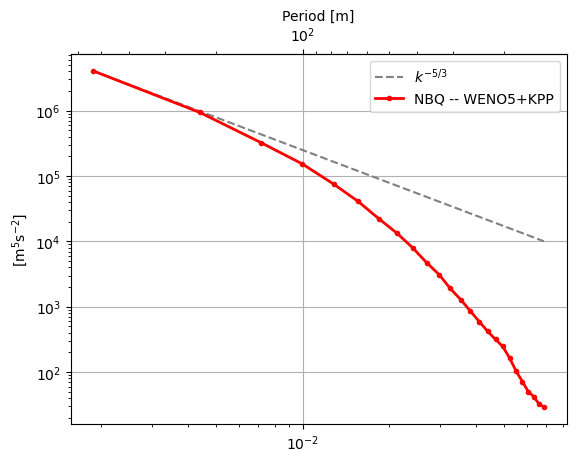

In [5]:
[kespec, freq_r] = croco.kespect(ds, tserie='partial', ttt=[-1], anoma=True, scaling='density')
#
def invert(x):
    # 1/x with special treatment of x == 0
    x = np.array(x).astype(float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = 1 / x[~near_zero]
    return x
#
dxy = ds.dx_rho.mean(dim=['eta_rho', 'xi_rho'])
fig0=plt.figure()
ax=fig0.add_subplot(111)
exp0 = -5/3
p00 = ax.plot(freq_r, \
               ((freq_r/dxy)**(exp0)/((freq_r/dxy)**(exp0))[0])*kespec[0][0], \
               color='gray', linestyle='--', label=r'$k^{-5/3}$')
p0 = ax.plot(freq_r, kespec[0], 'r.-', linewidth=2, label=r'NBQ -- WENO5+KPP')
plt.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'[m$^5$s${^{-2}}$]')
ax2 = ax.secondary_xaxis('top', functions=(invert, invert))
ax2.set_xlabel('Period [m]')
plt.grid()

# Extract Fourier modes and compute $a$

#### Should off-diagonal elements of $\textbf{a}$ be equal in spectral and physical space? -- **Answer : YES**  ... and they are

<18/04/2024: For some reasons, off-diagonal elements of $\textbf{a}$ are not identical in spectral and physical space, but I can't make sense if this is an issue in my code or can be associated with data iteslf. Gilles Tissot suggested the asymmetric behaviour of NBQ runs may be at the origin of this mismatch. I am taking these different steps to check this:

- 1/ Verified that $\left<{{\sigma \mathrm{d}B_t}^{(z)}}^{\scriptscriptstyle T}{\sigma \mathrm{d}B_t}^{(z)}\right>$, with $\left< \cdot \right>$ an ensemble averaging, converges toward $a_{zz}$. Using  1000 realisations already provides convergence tendencies. 
- 2/ Verified that the $\mathrm{d}B_t$ need to be identical othewise the expectation converges toward zero.
- 3/ $\left<{{\sigma \mathrm{d}B_t}^{(z)}}^{\scriptscriptstyle T}{\sigma \mathrm{d}B_t}^{(x)}\right>$ converges toward $a_{zx}$ estimates in physical space, suggesting spectral estimates are icorrect. 
- 4/ Realized that ```np.abs(u*v.conjugate())``` is different from ```(u*v.conjugate()).real``` if the real part is **negative** !!

**Conclusion (18/04/2024):** off-diagnoal elements must be computed as ```(u*v.conjugate()).real``` (and eventualy verify if the imaginary part is zero or not ...).

In [5]:
#- dummy spectra for indexing -
iit=-1
kkk=-1
da = xr.Dataset( )
da['u'] = grid_xy.interp(ds.u[iit, kkk, ...],'x')
da = da.rename({'eta_rho': 'y', 'xi_rho': 'x'})
dxy = ds.dx_rho.mean(dim=['eta_rho', 'xi_rho']).data
da = da.assign_coords({"y": ds.y_rho[:, 0].data, "x": ds.x_rho[0, :].data})
u_dft = xrft.fft(da.u, \
                   dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
dkdl=u_dft["freq_x"].spacing*u_dft["freq_y"].spacing

#
ds3 = xr.Dataset(
    data_vars=dict(
        uhat=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([ds.dims['time'], ds.dims['s_w'], ds.dims['eta_rho'], ds.dims['xi_rho']]), dtype='complex')),
        vhat=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([ds.dims['time'], ds.dims['s_w'], ds.dims['eta_rho'], ds.dims['xi_rho']]), dtype='complex')),
        what=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([ds.dims['time'], ds.dims['s_w'], ds.dims['eta_rho'], ds.dims['xi_rho']]), dtype='complex')),
        axx=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        ayy=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        azz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        axy=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        axz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
        ayz=(["time", "s_w"], np.zeros([ds.dims['time'], ds.dims['s_w']])),
    ),
    coords=dict(
        time=ds.time,
        s_rho=ds.s_rho,
        s_w=ds.s_w,
        freq_y=u_dft.freq_y,
        freq_x=u_dft.freq_x,
        y_rho=ds.y_rho,
        x_rho=ds.x_rho
    ),
    attrs=dict(description="Fourier modes and noise variance"),
)

Area = (ds.dx_rho*ds.dy_rho).sum()
tmp_tau=1.0
for iit in range(ds.dims['time']):
    #iit=-1
    print('-- time', iit, '/', ds.dims['time'], end='\r')
    da = xr.Dataset( )
    da['u'] = grid_z.interp(grid_xy.interp(ds.u[iit, ...],'x'),'z', boundary='extrapolate')
    da['v'] = grid_z.interp(grid_xy.interp(ds.v[iit, ...],'y'),'z', boundary='extrapolate')
    da['omega'] = ds.omega[iit, ...].drop(['x_rho', 'y_rho'])
    # adjust surface boundary condition for horizontal velocities
    da.u[-1, ...] = 0.
    da.v[-1, ...] = 0.
    # remove horizontal mean
    da=da-da.mean(dim=['eta_rho', 'xi_rho'])
    # rename and turn dimensions in meters (instead of grid index)
    da = da.rename({'eta_rho': 'y', 'xi_rho': 'x'})
    da = da.assign_coords({"y": ds.y_rho[:, 0].data, "x": ds.x_rho[0, :].data})
    #- Fourier modes [m3/s] -
    ds3.uhat[iit, ...] = xrft.fft(da.u, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    ds3.vhat[iit, ...] = xrft.fft(da.v, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    ds3.what[iit, ...] = xrft.fft(da.omega, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    #- covariance of the noise [m2/s] -
    ds3.axx[iit, :]=tmp_tau*( (ds3.uhat[iit, ...]*ds3.uhat[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area  # /Area because estimate spacial mean (not integral) KE
    ds3.ayy[iit, :]=tmp_tau*( (ds3.vhat[iit, ...]*ds3.vhat[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area
    ds3.azz[iit, :]=tmp_tau*( (ds3.what[iit, ...]*ds3.what[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area
    ds3.axy[iit, :]=tmp_tau*( (ds3.uhat[iit, ...]*ds3.vhat[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area
    ds3.axz[iit, :]=tmp_tau*( (ds3.uhat[iit, ...]*ds3.what[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area
    ds3.ayz[iit, :]=tmp_tau*( (ds3.vhat[iit, ...]*ds3.what[iit, ...].conjugate()).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area
    #- covariance matrix in physical space [m2/s2] -
    ds2.axx[iit, :]=(da.u**2).mean(dim=['y','x'])
    ds2.ayy[iit, :]=(da.v**2).mean(dim=['y','x'])
    ds2.azz[iit, :]=(da.omega**2).mean(dim=['y','x'])
    ds2.axy[iit, :]=(da.u*da.v).mean(dim=['y','x'])
    ds2.axz[iit, :]=(da.u*da.omega).mean(dim=['y','x'])
    ds2.ayz[iit, :]=(da.v*da.omega).mean(dim=['y','x'])
#
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

---- DONE ----433


'2025-06-13 10:02:27'

In [5]:
#-- construct distribution --
[mu, sigma] = [0.0, 1.0]
#-- compute sigdBt_z and associated covariance -> should match a_zz --
tmp_axz = xr.zeros_like(ds2.azz[-1, :])
tmp_azz = xr.zeros_like(ds2.azz[-1, :])
nmem = 500
for iii in range(nmem):
    print('-- ', iii, '/', nmem, end='\r')
    distrib =    np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y'])) \
             +1j*np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y']))
    #distrib2 =    np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y'])) \
    #         +1j*np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y']))
    #
    tmpw = (xrft.ifft(ds3.what.isel(time=-1), dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                  stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                            'y': 'eta_rho', \
                                                                            'x': 'xi_rho'}).assign_coords({\
                                                                                                           "eta_rho": ds.eta_rho.data, \
                                                                                                           "xi_rho": ds.xi_rho.data})
    tmpu = (xrft.ifft(ds3.uhat.isel(time=-1), dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                  stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                            'y': 'eta_rho', \
                                                                            'x': 'xi_rho'}).assign_coords({\
                                                                                                           "eta_rho": ds.eta_rho.data, \
                                                                                                           "xi_rho": ds.xi_rho.data})
    tmp_axz += ( (tmpw*tmpu).mean(dim=['eta_rho','xi_rho']) - tmp_axz) / (iii+1)
    tmp_azz += ( (tmpw*tmpw).mean(dim=['eta_rho','xi_rho']) - tmp_azz) / (iii+1)

#### Plot

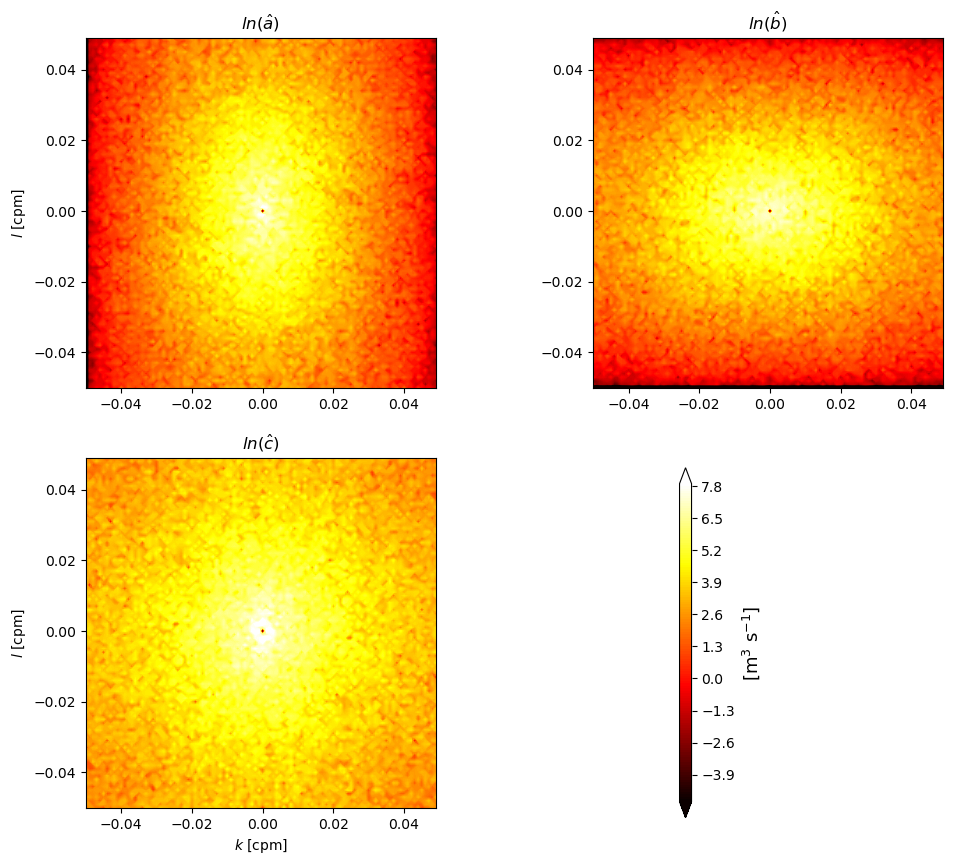

In [39]:
#-- Fourier modes --
import matplotlib.colors as clr
iit = -1
kkk=-15
saveF=False

#-- plot --
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
#
im1 = axes[0,0].contourf(ds3.freq_x, ds3.freq_y, np.log(np.abs(ds3.uhat[iit, kkk, ...])),\
                         cmap='hot', levels=np.arange(-5, 8, 0.1),extend='both')
axes[0,0].set(aspect=1., title=r"$ln(\hat{a})$", ylabel="$l$ [cpm]")
#
im2 = axes[0,1].contourf(ds3.freq_x, ds3.freq_y, np.log(np.abs(ds3.vhat[iit, kkk, ...])),\
                         cmap='hot', levels=np.arange(-5, 8, 0.1),extend='both')
axes[0,1].set(aspect=1., title=r"$ln(\hat{b})$",)
#
im2 = axes[1,0].contourf(ds3.freq_x, ds3.freq_y, np.log(np.abs(ds3.what[iit, kkk, ...])),\
                         cmap='hot', levels=np.arange(-5, 8, 0.1),extend='both')
axes[1,0].set(aspect=1., title=r"$ln(\hat{c})$", xlabel="$k$ [cpm]", ylabel="$l$ [cpm]")
#
fig.delaxes(axes[1][1])
cbaxes1 = fig.add_axes([0.65, 0.1, 0.01, 0.35]) 
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbaxes1)
cbar1.set_label(r"[m$^3$ s$^{-1}$]", fontsize=13)
#
if saveF:
    figN = "uvw_hz_Fourier_coef_NBQ"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

#### Note on units and consistancy between $\mathbf{a}$, $\mathbf{\sigma}\mathrm{d}B_t$ and covariance of noise

- when expressing noise and its variance from model velocities, we use this def.

$\mathbf{\sigma}\mathrm{d}B_t = \sqrt{\tau} \sum_k \sqrt{\lambda}_k \mathbf{\phi}_k \mathrm{d}B_t^k$

$\mathbf{a}\mathrm{d}t = cov(\mathbf{\sigma}\mathrm{d}B_t^i, \mathbf{\sigma}\mathrm{d}B_t^j) = \tau \sum_k \lambda_k \mathbf{\phi}_k \mathbf{\phi}_k^{\scriptscriptstyle T} \mathrm{d}t$

with the following units: $[\mathbf{\phi}]=[m~s^{-1}] $&emsp; ; &emsp; $[\mathrm{d}B_t]=[\sqrt{s}] $&emsp; ; &emsp; $[\tau]=[s]$, 

hence $\mathbf{\sigma}\mathrm{d}B_t$ has unit of deplacement in $[m]$ and $\mathbf{a}\mathrm{d}t$ has unit of squared desplacement in $[m^2]$.

Setting $\tau=1~s$ leads to a comparison of $\mathbf{a}$ with covariance of velocities $\mathbf{u}\mathbf{u}^{\scriptscriptstyle T}$, although they don't have the same units.

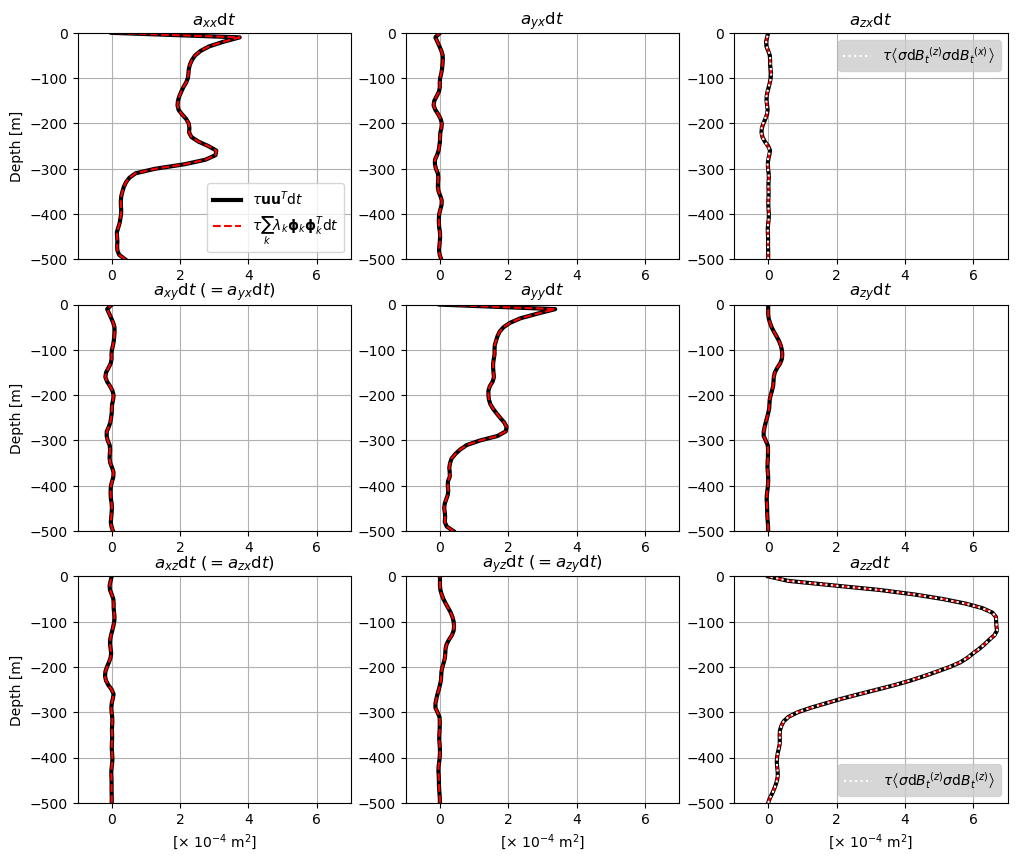

In [28]:
#-- Depth depend 1-point covariance matrix --
saveF=True
scaleF=1e4
#-- plot --
fig, axes = plt.subplots(figsize=(12,10), nrows=3, ncols=3)
ttit=np.array([[r'$a_{xx}\mathrm{d}t$', r'$a_{yx}\mathrm{d}t$', r'$a_{zx}\mathrm{d}t$'], \
               [r'$a_{xy}\mathrm{d}t~(=a_{yx}\mathrm{d}t)$', r'$a_{yy}\mathrm{d}t$', r'$a_{zy}\mathrm{d}t$'], \
               [r'$a_{xz}\mathrm{d}t~(=a_{zx}\mathrm{d}t)$', r'$a_{yz}\mathrm{d}t~(=a_{zy}\mathrm{d}t)$', r'$a_{zz}\mathrm{d}t$']])
iit=-1
#
axes[0,0].plot(ds2.axx[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3, label=r"$\tau\mathbf{u}\mathbf{u}^{T}\mathrm{d}t$")
axes[0,0].plot(ds3.axx[iit, :]*scaleF,ds3.s_w*500, 'r--', \
               label=r"$\tau \sum_k \lambda_k \mathbf{\phi}_k \mathbf{\phi}_k^{T} \mathrm{d}t$")
axes[0,0].legend()
axes[0,1].plot(tmp_tau*ds2.axy[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[0,1].plot(ds3.axy[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[0,2].plot(tmp_tau*ds2.axz[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[0,2].plot(ds3.axz[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[0,2].plot(tmp_axz*scaleF,ds3.s_w*500, 'w:',  label=r'$\tau\left<{{\sigma \mathrm{d}B_t}^{(z)}}{\sigma \mathrm{d}B_t}^{(x)} \right>$')
axes[0,2].legend(facecolor=[0.8, 0.8, 0.8])
axes[1,0].plot(tmp_tau*ds2.axy[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[1,0].plot(ds3.axy[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[1,1].plot(tmp_tau*ds2.ayy[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[1,1].plot(ds3.ayy[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[1,2].plot(tmp_tau*ds2.ayz[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[1,2].plot(ds3.ayz[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[2,0].plot(tmp_tau*ds2.axz[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[2,0].plot(ds3.axz[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[2,1].plot(tmp_tau*ds2.ayz[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[2,1].plot(ds3.ayz[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[2,2].plot(tmp_tau*ds2.azz[iit, :]*scaleF,ds2.s_w*500, 'k', lw=3)
axes[2,2].plot(ds3.azz[iit, :]*scaleF,ds3.s_w*500, 'r--')
axes[2,2].plot(tmp_azz*scaleF,ds3.s_w*500, 'w:', label=r'$\tau\left<{{\sigma \mathrm{d}B_t}^{(z)}}{\sigma \mathrm{d}B_t}^{(z)} \right>$')
axes[2,2].legend(facecolor=[0.8, 0.8, 0.8])
for iip in range(3):
    for jjp in range(3):
        #axes[jjp,iip].plot(aaa[:,jjp,iip],da.z*500, 'k')
        axes[jjp,iip].set(title=ttit[jjp,iip], ylim=[-500, 0], xlim=[-1, 7])
        axes[jjp,iip].grid()
        if jjp==0:
            axes[iip,jjp].set(ylabel='Depth [m]')
        if iip==2:
            axes[iip,jjp].set(xlabel=r"[$\times$ 10$^{-4}$ m$^2$]")
#
if saveF:
    figN = "1point_cov_mat_Fourier_physical"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

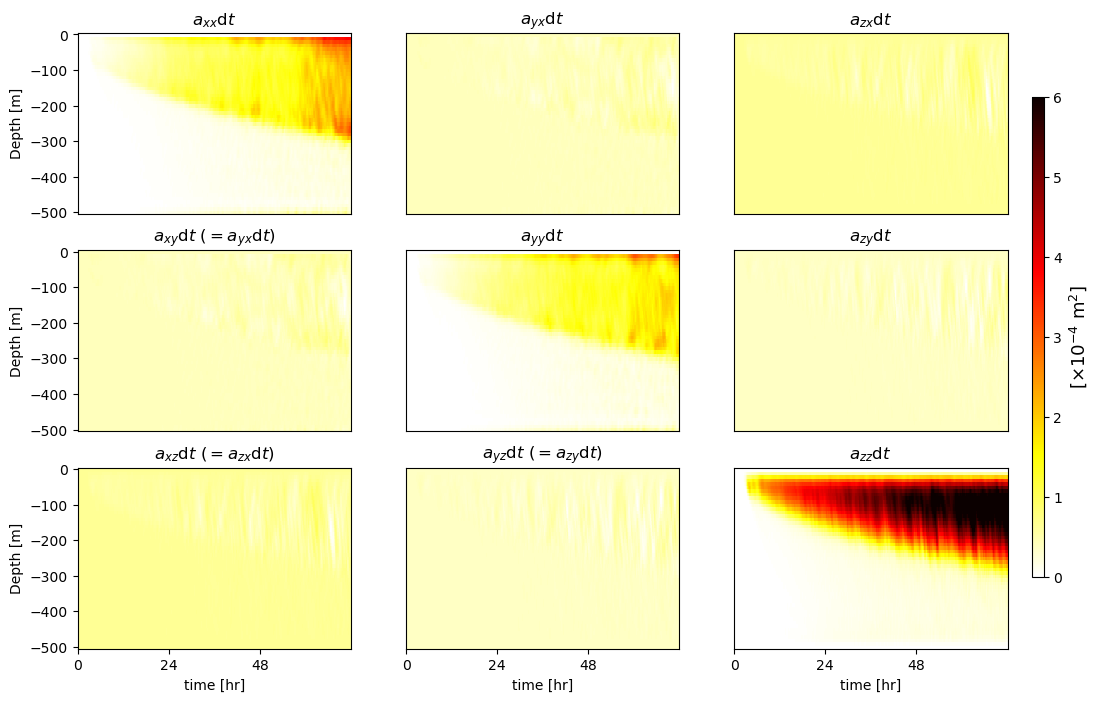

In [15]:
#-- Depth and time depend 1-point covariance matrix --
saveF=True
scaleF=1e4
#-- plot --
fig, axes = plt.subplots(figsize=(12,8), nrows=3, ncols=3)
ttit=np.array([[r'$a_{xx}\mathrm{d}t$', r'$a_{yx}\mathrm{d}t$', r'$a_{zx}\mathrm{d}t$'], \
               [r'$a_{xy}\mathrm{d}t~(=a_{yx}\mathrm{d}t)$', r'$a_{yy}\mathrm{d}t$', r'$a_{zy}\mathrm{d}t$'], \
               [r'$a_{xz}\mathrm{d}t~(=a_{zx}\mathrm{d}t)$', r'$a_{yz}\mathrm{d}t~(=a_{zy}\mathrm{d}t)$', r'$a_{zz}\mathrm{d}t$']])
#
im1=axes[0,0].pcolor(ds.time/3600, ds2.s_w*500, ds3.axx.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[0,1].pcolor(ds.time/3600, ds2.s_w*500, ds3.axy.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[0,2].pcolor(ds.time/3600, ds2.s_w*500, ds3.axz.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[1,0].pcolor(ds.time/3600, ds2.s_w*500, ds3.axy.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[1,1].pcolor(ds.time/3600, ds2.s_w*500, ds3.ayy.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[1,2].pcolor(ds.time/3600, ds2.s_w*500, ds3.ayz.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[2,0].pcolor(ds.time/3600, ds2.s_w*500, ds3.axz.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[2,1].pcolor(ds.time/3600, ds2.s_w*500, ds3.ayz.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
im1=axes[2,2].pcolor(ds.time/3600, ds2.s_w*500, ds3.azz.transpose('s_w','time')*scaleF, vmax=6, cmap='hot_r')
for iip in range(3):
    for jjp in range(3):
        axes[jjp,iip].set(title=ttit[jjp,iip], xticks=np.arange(0, 72, 24))
        if iip==0:
            axes[jjp,iip].set(ylabel='Depth [m]')
        else:
            axes[jjp,iip].get_yaxis().set_visible(False)
        if jjp==2:
            axes[jjp,iip].set(xlabel=r"time [hr]")
        else:
            axes[jjp,iip].get_xaxis().set_visible(False)
#
cbaxes1 = fig.add_axes([0.92, 0.2, 0.01, 0.6]) 
cbar1 = fig.colorbar(im1, orientation='vertical', cax=cbaxes1)
cbar1.set_label(r"[$\times$10$^{-4}$ m$^2$]", fontsize=13)
#
if saveF:
    figN = "1point_cov_mat_Spatial_z_time_dependent"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

# Compute stochastic vertical 'velocity' ${\sigma \mathrm{d} B_t}^{(z)}$ and compare to $w$

**note**: verified that $\nabla \cdot \boldsymbol{\sigma} \mathrm{d} \mathbf{B}_t=0$

In [16]:
tmp_tau=1.0
[mu, sigma] = [0.0, 1.0]
distrib =    np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y'])) \
         +1j*np.random.normal(mu, sigma, (ds3.dims['freq_y'], ds3.dims['freq_y']))
# inverse fourier transform with stochastic perturbations
ds['sigdBt_z'] = tmp_tau*(xrft.ifft(ds3.what, dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                            stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                                      'y': 'eta_rho', \
                                                                                      'x': 'xi_rho'}).assign_coords({\
                                                                                                                     "eta_rho": ds.eta_rho.data, \
                                                                                                                     "xi_rho": ds.xi_rho.data})

In [17]:
iit = -1
kkk = -15
#evaluate skewness
wstd     = ds.omega[iit, kkk, ...].data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]).std(ddof=1)
sigz_std = ds.sigdBt_z[iit, kkk, ...].data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]).std(ddof=1)
print(r"($\sigma^2(WVEL)$, $\sigma^2(sigz)$) = (%f, %f)" %(wstd, sigz_std))
#
skew_wvel = (( (ds.omega[iit, kkk, ...])/wstd)**3).mean()
skew_sigz = (( (ds.sigdBt_z[iit, kkk, ...])/sigz_std)**3).mean()
print("Skewness WVEL: %f" % skew_wvel)
print("Skewness sigz: %f" % skew_sigz)

($\sigma^2(WVEL)$, $\sigma^2(sigz)$) = (0.025429, 0.026266)
Skewness WVEL: -0.999018
Skewness sigz: -0.194692


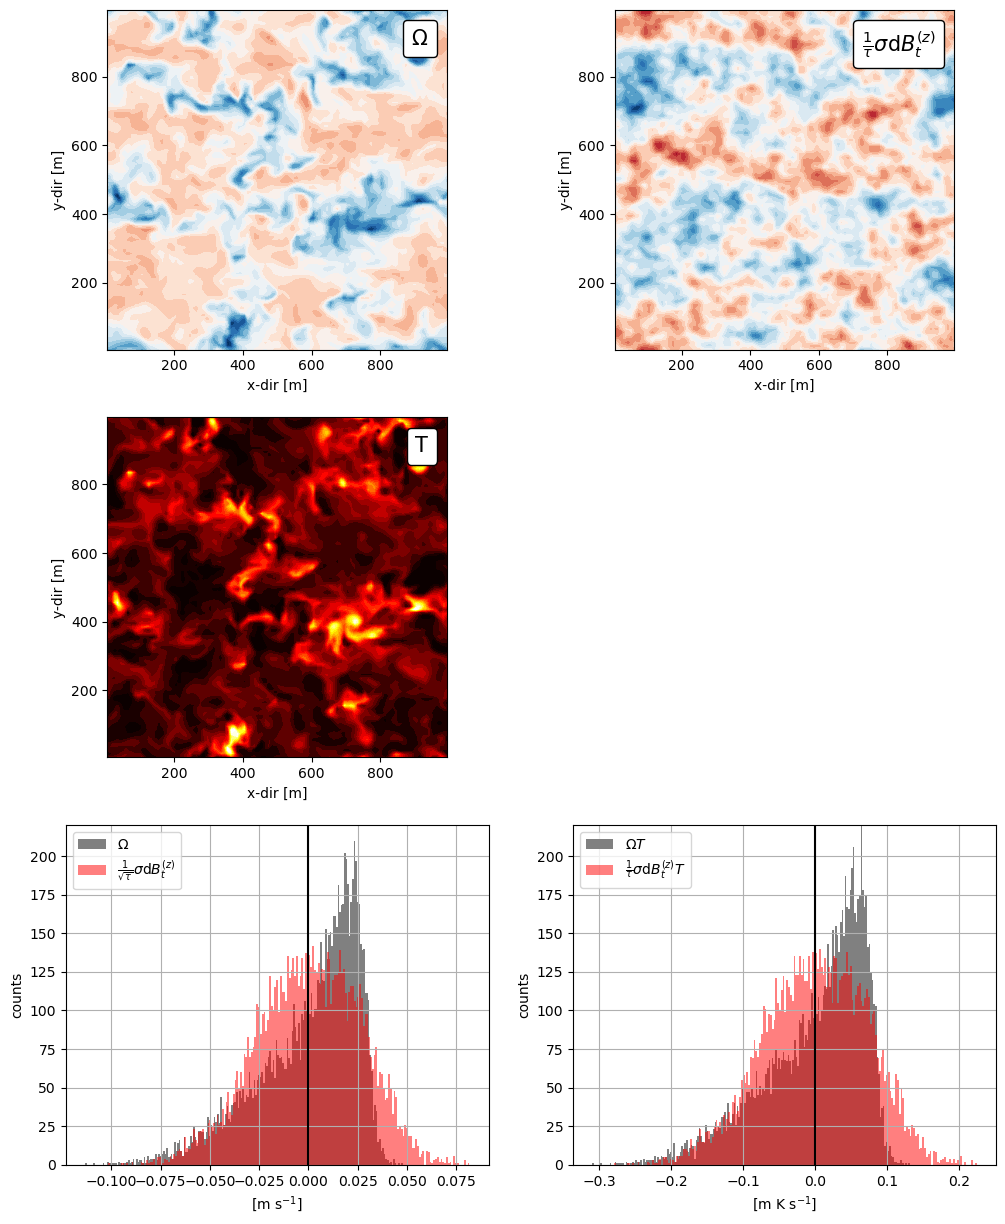

In [19]:
saveF=False
llev1=np.arange(-1.0, 1.1, 0.1)*1e-1
llev2=np.arange(2.73, 2.75, 0.001)
bbins = 200
#--
fig, ax = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
#
cs0 = ax[0,0].contourf(ds.x_rho[0,:],ds.y_rho[:,0],ds.omega[iit,kkk,...],levels=llev1, cmap='RdBu_r', extend='both')
croco.my_tit(ax[0,0],r'$\Omega$')
ax[0,0].set(aspect=1, xlabel='x-dir [m]', ylabel='y-dir [m]')
#
ax[0,1].contourf(ds.x_rho[0,:],ds.y_rho[:,0],ds.sigdBt_z[iit,kkk,...],levels=llev1, cmap='RdBu_r', extend='both')
croco.my_tit(ax[0,1],tit=r'$\frac{1}{\tau}\sigma \mathrm{d}B_t^{(z)}$')
ax[0,1].set(aspect=1, xlabel='x-dir [m]', ylabel='y-dir [m]')
#
ax[1,0].contourf(ds.x_rho[0,:],ds.y_rho[:,0],ds.temp[iit,kkk,...],levels=llev2, cmap='hot_r', extend='both')
croco.my_tit(ax[1,0],tit=r'T')
ax[1,0].set(aspect=1, xlabel='x-dir [m]', ylabel='y-dir [m]')
#
ax[2,0].plot([0,0], [0,220], 'k')
n1, bins1, patches1 = ax[2,0].hist((ds.omega[iit,kkk,...]).data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]), \
                                   bins=bbins, facecolor='grey', alpha=1, label=r'$\Omega$')
n2, bins2, patches2 = ax[2,0].hist((ds.sigdBt_z[iit,kkk,...]).data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]), \
                                   bins=bbins, facecolor='r', alpha=0.5, label=r'$\frac{1}{\sqrt{\tau}}\sigma \mathrm{d}B_t^{(z)}$')
ax[2,0].set(xlabel=r'[m s$^{-1}$]', ylabel='counts', ylim=[0, 220])
ax[2,0].legend(loc='upper left')
ax[2,0].grid()
#
ax[2,1].plot([0,0], [0,220], 'k')
n1, bins1, patches1 = ax[2,1].hist((ds.omega[iit,kkk,...]*0.5*(ds.temp[iit,kkk, ...].data+ds.temp[iit,kkk+1, ...].data) ).data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]), \
                                   bins=bbins, facecolor='grey', alpha=1, label=r'$\Omega T$')
n2, bins2, patches2 = ax[2,1].hist((ds.sigdBt_z[iit,kkk,...]*0.5*(ds.temp[iit,kkk, ...].data+ds.temp[iit,kkk+1, ...].data)).data.reshape([ds.dims['eta_rho']*ds.dims['xi_rho']]), \
                                   bins=bbins, facecolor='r', alpha=0.5, label=r'$\frac{1}{\tau}\sigma \mathrm{d}B_t^{(z)} T$')
ax[2,1].set(xlabel=r'[m K s$^{-1}$]', ylabel='counts', ylim=[0, 220])
ax[2,1].legend(loc='upper left')
ax[2,1].grid()
#
ax[1,1].set_axis_off()
#
if saveF:
    figN = "omega_sigdBtz_snap_hz_section"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

---
---

# Compute the different terms of the hz avg stochastic temperature equation, with time filtering

---
---

We consider the stochastic transport of temperature in the systeme of equations (49) in Tissot et al. (2022) \[in the updated version of this manuscript, in preparation for submission, this has becom system (64) \], which is obtained through the derivation of a compressible non-hydrostatic stochastic EDP for temperature on which assumptions of low Mach number (i.e. incompressibility) and quasi-nonhydrostatic (i.e. $(\partial_t  + \textbf{u}\cdot\nabla) w \sim \mathcal{O}(\epsilon) $) assumptions have been applied. This stochastic transport equation for 3D temperature field can be further simplified in ou case through a horizontal averaging ($\overline{\bullet}=\frac{1}{A}\int_x\int_y \bullet dx dy$), leading to a stochastic transport equation for a 1D vertical profil of temperature. The details are given in this note:

- [https://www.overleaf.com/read/gfyjhfkfdcyk#2b07d7](https://www.overleaf.com/read/gfyjhfkfdcyk#2b07d7)

and we will refer in the following to the different contributions of the equation (24) of this note (reproduced bellow) with upper case letters as:

$$
\begin{equation}
\begin{aligned}
     \rho_0(\frac{1}{\gamma} -g \beta_T (\eta - z) ) \mathrm{d}_t \overline{T} =& 
    \rho_0(\frac{1}{\gamma} -g \beta_T (\eta - z) ) \left(
    - \underbrace{\partial_z \overline{wT} \mathrm{d}t}_{(A)}
    + \underbrace{\frac{1}{2}\left( \partial_z a_{zz} \right) \partial_z \overline{T} \mathrm{d}t}_{(B)}
    - \underbrace{ \partial_z \overline{ (\sigma \mathrm{d} B_t^{(z)} T) }}_{(C)}
    + \underbrace{\frac{1}{2}\partial_z \left( a_{zz}\partial_z \overline{T} \right) \mathrm{d}t}_{(D)}
    \right)\\
       &%+\underbrace{\frac{\rho_0}{2} \left( \partial_z a_{zz} \right) \overline{b}^{xy} \mathrm{d}t}_{(F)}
       - \underbrace{\partial_z (\overline{\sigma \mathrm{d} B_t^{(z)} p_{qnh}) }}_{(G)}
       - \underbrace{\frac{\rho_0}{2}\left(\partial_z a_{zz}\right) \overline{ \sigma \mathrm{d} B_t^{(z)} \partial_z w } }_{(I)}
       - \overline{A_T} 
       - \overline{A_u}
       + \overline{Q_{rad}} \mathrm{d}t.
\end{aligned}
\end{equation}
$$

Addimentionalisation in Tissot et al. (2022), where quantities with $\bullet^{\phi}$ are physical variables.

$\mathbf{g}=\frac{\mathbf{g}^{\phi}L_{ref}}{u_{ref}^2}$ &emsp; ; &emsp; $T=\frac{T^{\phi}c_p^{\phi}}{u^2_{ref}}$ &emsp; ; &emsp; $p=\frac{p^{\phi}}{\rho_{ref}u^2_{ref}}$ &emsp; ; &emsp; $\rho=\frac{\rho^{\phi}}{\rho_{ref}}$ &emsp; ; &emsp; $e=\frac{e^{\phi}}{u_{ref}^2}=\frac{T}{\gamma}$ &emsp; ; &emsp; $\gamma=\frac{C_p^{\phi}}{C_v^{\phi}}$ &emsp; ; &emsp; $b=-\frac{\epsilon\rho^{\phi}_2}{\rho^{\phi}_0}\mathbf{g}^{\phi}\frac{L_{ref}}{u^2_{ref}}=b^{\phi}\frac{L_{ref}}{u^2_{ref}}$ &emsp; ; &emsp; $t=\frac{t^{\phi}u_{ref}}{L_{ref}}$ &emsp; ; &emsp; $\beta_T = \frac{u^2_{ref}}{c_p^{\phi}} \beta_T^{\phi}$

with

$L_{ref}=1~m$ &emsp; ; &emsp; $\rho_{ref}=1024$ &emsp; ; &emsp; $u_{ref}=1~m.s^{-1}$ &emsp; ; &emsp; $c_p^{\phi}=c_v^{\phi}=3985~J.K^{-1}.kg^{-1}$
<br/>

*<h6>Tissot, G., Mémin, E., Jamet, Q. (2022) Stochastic compressible Navier–Stokes equations under location uncertainty. Stochastic Transport in Upper Ocean Dynamics Annual Workshop, Springer.<h6>*
    
**!! ALL QUANTITIES ARE COMPUTED WITH THEIR ASSOCIATED SIGN ON THE RHS !!**

## Some functions

In [5]:
############
def comp_sigdBt(ds_in, mu, sigma, tau, ds_ref):
    #
    ds_out = xr.Dataset( )
    # pick one of the time frame, randomly
    iiit = int(np.random.uniform(0, ds_in.dims['time'], 1))
    #
    distrib =    np.random.normal(mu, sigma, (ds_in.dims['freq_y'], ds_in.dims['freq_y'])) \
             +1j*np.random.normal(mu, sigma, (ds_in.dims['freq_y'], ds_in.dims['freq_y']))
    #- stochastic vel (at w-pts) -
    ds_out["sigdB_x"] = np.sqrt(tau) * (xrft.ifft(ds_in.uhat.isel(time=iiit), dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                      stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                                'y': 'eta_rho', \
                                                                                'x': 'xi_rho'}).assign_coords({\
                                                                                                               "eta_rho": ds_ref.eta_rho.data, \
                                                                                                               "xi_rho": ds_ref.xi_rho.data}) * dBt
    ds_out["sigdB_y"] = np.sqrt(tau) * (xrft.ifft(ds_in.vhat.isel(time=iiit), dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                      stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                                'y': 'eta_rho', \
                                                                                'x': 'xi_rho'}).assign_coords({\
                                                                                                               "eta_rho": ds_ref.eta_rho.data, \
                                                                                                               "xi_rho": ds_ref.xi_rho.data}) * dBt
    ds_out["sigdB_z"] = np.sqrt(tau) * (xrft.ifft(ds_in.what.isel(time=iiit), dim=['freq_x','freq_y'], true_phase=True, true_amplitude=True, \
                      stochastic=True, distrib=distrib).compute()).real.rename({\
                                                                                'y': 'eta_rho', \
                                                                                'x': 'xi_rho'}).assign_coords({\
                                                                                                               "eta_rho": ds_ref.eta_rho.data, \
                                                                                                               "xi_rho": ds_ref.xi_rho.data}) * dBt
    return ds_out, iiit


def comp_dptsig(ds_sig, www, order='top-down'):
    # dptsig is defined at w-points with 0 upper boundary condition ; Note that both top-down and bottom-up definition of dptsig leads to the same hz avg estimates of dptsig,
    # but local estimates differ.
    if order == 'top-down':
        dptsig = -rho0 * grid_z.cumsum( \
                                      (( \
                                        grid_z.interp( \
                                                      grid_xy.interp(grid_xy.diff(ds_sig.sigdB_x*www, 'x')/ds.dx_u, 'x') \
                                                     +grid_xy.interp(grid_xy.diff(ds_sig.sigdB_y*www, 'y')/ds.dy_v, 'y'), \
                                                      'z')
                                       +grid_z.diff(ds_sig.sigdB_z*www, 'z')/ds.dz_rho \
                                       )*ds.dz_rho)[::-1, ...],\
                                      'z', boundary='fill', fill_value=0.)[::-1, ...]
        #
        dptsig['s_rho'] = dptsig.s_w[::-1]
    elif order == 'bottom-up':    
        dptsig = rho0 * grid_z.cumsum( \
                                      (( \
                                        grid_z.interp( \
                                                      grid_xy.interp(grid_xy.diff(ds_sig.sigdB_x*www, 'x')/ds.dx_u, 'x') \
                                                     +grid_xy.interp(grid_xy.diff(ds_sig.sigdB_y*www, 'y')/ds.dy_v, 'y'), \
                                                      'z')
                                       +grid_z.diff(ds_sig.sigdB_z*www, 'z')/ds.dz_rho \
                                       )*ds.dz_rho),\
                                      'z', boundary='fill', fill_value=0.)
    return dptsig

## Adimentionalisation and time params

In [6]:
Cp=Cv=3985.                        # [J K^{-1} kg^{-1}] -- from scalar.h
gamma=Cp/Cv
rhoRef=1024.
Lref=1.
Uref=1.
tRef=Lref/Uref
#from adimentionalization
cff = 1./rhoRef/Uref**2
nmem = 500
# stochastic distribution
mu = 0.
sigma = 1.0
#- time parameters -
iit    = 360                          # time of interest -- 60 hrs
deltaT = 600                          # freq of outputs
#Nint   = 18                           # Nint=18 -> 3 hours == decorrelation timescale ; used to apply time filtering
dt     = Nint*deltaT
#stochastic time parameters
tau    = 175
dBt    = Nint*np.sqrt(deltaT)
#
iit0=iit-int(Nint/2)
iit1=iit+int(Nint/2)
#
Area = (ds.dx_rho*ds.dy_rho).sum()

## Time series of total energy and its decomposition

The (non-dimensional) total energy is defined as:
$$
\begin{equation}
\begin{aligned}
    \rho E = \rho \left( e + \frac{1}{2} ||\mathbf{u}||^2 + gz \right)
\end{aligned}
\end{equation}
$$
with the (non-dimensional) internal energy $e=\frac{T}{\gamma}$. Using the non-dimentionalisation above, we have:

$$
\begin{equation}
\begin{aligned}
   \frac{1}{\rho_{ref}u_{ref}^2} \rho^{\phi} E^{\phi} = \frac{1}{\rho_{ref}u_{ref}^2} \rho^{\phi} \left( T^{\phi}C_v^{\phi} + \frac{1}{2} ||\mathbf{u}^{\phi}||^2 + g^{\phi}z^{\phi} \right)
\end{aligned}
\end{equation}
$$

Note: the adimentionalization factor $\frac{1}{\rho_{ref}u_{ref}^2}$ is the same than that obtained for temperature equation.

In [52]:
#-- integrated heat fluxes --
Q = cff * (-qnet) * ds.time / ds.dz_rho.mean(dim=['eta_rho', 'xi_rho']).sum(dim=['s_rho'])
#-- internal energy --
tmp_e = cff * Cv * ((ds.rho+1000.) * ds.temp ).mean(dim=['s_rho', 'eta_rho','xi_rho'])
e = cff * Cv * rho0 * ds.temp.mean(dim=['s_rho', 'eta_rho','xi_rho'])
#-- PE --
pe_anoma =   -cff * g * ( (ds.rho+1000. - (ds.rho+1000.).isel(time=0).mean(dim=['eta_rho', 'xi_rho']) ) * (ds.z_rho) ).mean(dim=['s_rho', 'eta_rho','xi_rho'])
#-- KE --
ke = cff * 0.5 * ((ds.rho+1000.) * (grid_xy.interp(ds.u**2, 'x') + grid_xy.interp(ds.v**2, 'y') + grid_z.interp(ds.omega**2, 'z') ) ).mean(dim=['s_rho', 'eta_rho','xi_rho'])

In [53]:
# based on dynamic enthalpy -- it's a linear function, so ensemble mean of eddy PE = 0
# should be integrated top down, not bottom up -- hence the - signe in pe_h...
h  = ( (ds.bbb - ds.bbb.isel(time=0).mean(dim=['eta_rho', 'xi_rho'])) * ds.dz_rho).cumsum(dim='s_rho') 
hm = ( (ds.bbb - ds.bbb.isel(time=0).mean(dim=['eta_rho', 'xi_rho'])).mean(dim=['eta_rho', 'xi_rho']) * ds.dz_rho_1d).cumsum(dim='s_rho')
pe_h  = h.mean(dim=['s_rho', 'eta_rho','xi_rho'])
pe_hm = hm.mean(dim=['s_rho'])

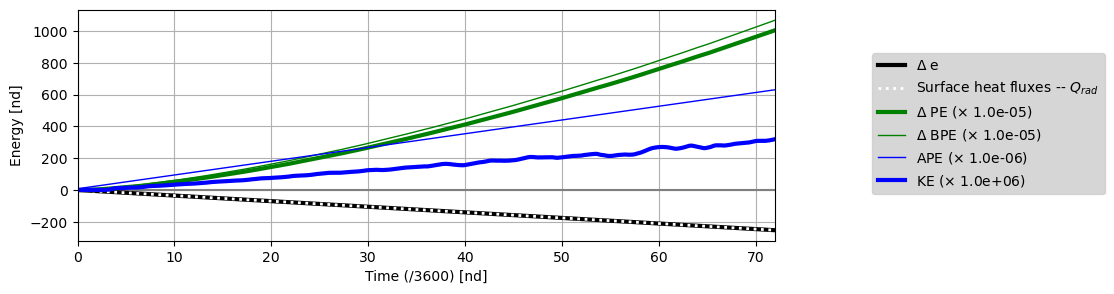

In [12]:
saveF=False
scaleF_pe = 1e5
scaleF_ke = 1e6
#
fig, ax = plt.subplots(figsize=(9,3), nrows=1, ncols=1)
#
ax.plot(tRef*ds.time/3600, np.zeros(ds.dims['time']), 'gray')
# internal energy
ax.plot(tRef*ds.time/3600, (e-e.isel(time=0)), 'k', lw=3, label=r'$\Delta$ e')
# surface heat flux
ax.plot(tRef*ds.time/3600, Q, 'w:', lw=2, label=r'Surface heat fluxes -- $Q_{rad}$')
# PE
ax.plot(tRef*ds.time/3600, (pe_anoma)*scaleF_pe, color='green', lw=3, label=str(r'$\Delta$ PE ($\times$ %.01e)' % (1/scaleF_pe)))
#- based on BPE à la Tailleux -
# BPE
#ax.plot(ds.time/3600, (-bpe+bpe[0])*scaleF_pe, color='green', lw=1, alpha=0.5)#, label=str(r'$\Delta$ pe ($\times$ %.01e)' % (1/scaleF_pe)))
#ax.plot(ds.time/3600, (pe-pe.isel(time=0))*scaleF_pe, color='green', lw=3, label=str(r'$\Delta$ pe ($\times$ %.01e)' % (scaleF_pe)))
#- based on dynamic enthalpie -
# BPE
ax.plot(tRef*ds.time/3600, -pe_h*scaleF_pe, color='green', lw=1, label=str(r'$\Delta$ BPE ($\times$ %.01e)' % (1/scaleF_pe)))
# APE
ax.plot(tRef*ds.time/3600, (-pe_h-pe_anoma)*scaleF_ke, color='b', lw=1, label=str(r'APE ($\times$ %.01e)' % (1/scaleF_ke)))
#-
# KE
ax.plot(tRef*ds.time/3600, ke*scaleF_ke, color='b', lw=3, label=str(r'KE ($\times$ %.01e)' % (scaleF_ke)))
#ax.set(xlabel='Time [hr]', ylabel=str(r'Energy [J m$^{-3}$]'), xlim=[0, 72])  # if not * cff
ax.set(xlabel='Time (/3600) [nd]', ylabel=str(r'Energy [nd]'), xlim=[0, 72])
fig.legend(facecolor=[0.8, 0.8, 0.8],loc='center left',bbox_to_anchor=(1., 0., 1., 1.))
plt.grid()
#
if saveF:
    figN = "Time_series_internal_potential_h_kinetic_nrj_and_heat_fluxes_adim"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

## Construct time filtered dataset

In [7]:
dsm = xr.Dataset(
    data_vars=dict(
        rhsC=(["memb", "s_rho"], np.zeros([nmem, ds.dims['s_rho']])),
        rhsC_BQ=(["memb", "s_rho"], np.zeros([nmem, ds.dims['s_rho']])),
        Dt_sto=(["memb", "s_rho"], np.zeros([nmem, ds.dims['s_rho']])),
        Dsig=(["memb", "s_rho"], np.zeros([nmem, ds.dims['s_rho']])),
        At=(["s_w"], np.zeros([ds.dims['s_w']])),
        At_F=(["s_w"], np.zeros([ds.dims['s_w']])),
        Au=(["s_w"], np.zeros([ds.dims['s_w']])),
        Psig=(["s_w"], np.zeros([ds.dims['s_w']])),
    ),
    coords=dict(ds.coords, memb=np.arange(nmem)),
    attrs=dict(description="Time filetered dataset"))
dsm = dsm.isel(time=slice(iit0, iit1))
#-- metric - get the list with list(ds.keys()) --
mmetric=['z_rho',
 'z_w',
 'z_rho_1d',
 'z_w_1d',
 'dz_rho',
 'dz_w',
 'dz_rho_1d',
 'dz_w_1d',
 'dx_rho',
 'dy_rho',
 'dx_u',
 'dy_u',
 'dx_v',
 'dy_v',
 'dx_psi',
 'dy_psi',
 'dz_u',
 'dz_v',
 'dz_psi']
for im in mmetric:
    dsm[im] = eval("ds.%s" % im )
#-- variables --
dsm["temp"] = ds.temp.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["rho"]  = ds.rho.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm['bbb']  = ds.bbb.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm['kmld'] = ds.kmld.isel(time=iit0)
dsm['mld']  = ds.mld.isel(time=iit0)
#dsm['bbb_r']  = ds.bbb_r.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["Um"] = ds.u.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["Upr"] = ds.u.isel(time=slice(iit0, iit1)) - dsm.Um
dsm["Vm"] = ds.v.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["Vpr"] = ds.v.isel(time=slice(iit0, iit1)) - dsm.Vm
dsm["Wm"] = ds.omega.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["Wpr"] = ds.omega.isel(time=slice(iit0, iit1)) - dsm.Wm
# vertical temperature fluxes
dsm["wTm"] = ds.wT.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["wTpr"] = ds.wT.isel(time=slice(iit0, iit1)) - dsm.wTm
dsm["wTm_sgs"] = ds.wT_sgs.isel(time=slice(iit0, iit1)).mean(dim='time')
dsm["wTpr_sgs"] = ds.wT_sgs.isel(time=slice(iit0, iit1)) - dsm.wTm_sgs
dsm["wmTm"] = (dsm.Wm*grid_z.interp(dsm.temp, 'z', boundary='extrapolate'))
dsm.wmTm[-1] = 0.
# variance of the noise, in m2/s
dsm["axx"] = tau * (dsm.Upr**2).mean(dim='time').mean(dim=['eta_rho', 'xi_u'  ])
dsm["ayy"] = tau * (dsm.Vpr**2).mean(dim='time').mean(dim=['eta_v'  , 'xi_rho'])
dsm["azz"] = tau * (dsm.Wpr**2).mean(dim='time').mean(dim=['eta_rho', 'xi_rho'])
# \partial_z \overline{T}
dsm["dTdz"] = grid_z.diff(dsm.temp.mean(dim=['eta_rho', 'xi_rho']), 'z', boundary='extrapolate')/dsm.dz_w_1d

#
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

---- DONE ----


'2025-06-13 13:45:30'

### decorrelation timescale

In [12]:
decor_time=xr.Dataset()
#
tmpu = dsm.Upr.stack(xy=("eta_rho", "xi_u"  ))
tmpv = dsm.Vpr.stack(xy=("eta_v"  , "xi_rho"))
tmpw = dsm.Wpr.stack(xy=("eta_rho", "xi_rho"))
#
decor_time["lag_covar_u"]=(((tmpu[0, ...]*tmpu)).mean(dim=['xy']))/ \
     (tmpu[0, ...].std(dim='xy', ddof=1)*tmpu.std(dim='xy', ddof=1))
decor_time["lag_covar_v"]=(((tmpv[0, ...]*tmpv)).mean(dim=['xy']))/ \
     (tmpv[0, ...].std(dim='xy', ddof=1)*tmpv.std(dim='xy', ddof=1))
decor_time["lag_covar_w"]=(((tmpw[0, ...]*tmpw)).mean(dim=['xy']))/ \
     (tmpw[0, ...].std(dim='xy', ddof=1)*tmpw.std(dim='xy', ddof=1))

In [23]:
def get_decorr_time(da, time, thresh=0.2):
    if 's_rho' in da.dims:
        nz=ds.dims['s_rho']
    elif 's_w' in da.dims:
        nz=ds.dims['s_w']
    else:
        print('-- Unknown vertical dimension --')
        return
    #
    tmpout=np.zeros(nz)
    for kkk in range(nz):
        test = np.where(da[kkk, :] <= thresh)[0]
        if not test.size > 0 :
            print("--- No value below threshold %f ---" % thresh)
            tmpout[kkk] = np.nan
        else:
            idecorr = test[0]
            tmpout[kkk] = time[idecorr]-time[0]
    #
    return tmpout
#        
for ivar in ["u", "v", "w"]:
    print("-> decorrelation time for %s" % ivar)
    if ivar == 'w':
        ddim="s_w"
    else:
        ddim="s_rho"
    #
    varN = str("decor_t_%s" % ivar)
    tmptime = xr.DataArray( 
        data = get_decorr_time(eval("decor_time.lag_covar_%s"% ivar), ds.time.isel(time=slice(iit0, iit1)), thresh=0.2),
        dims=[ddim])
    decor_time[varN] = tmptime
    #
    varN2 = str('decor_ratio_%s' % ivar)
    decor_time[varN2] = tmptime/tmptime[dsm.kmld.astype(int)]

-> decorrelation time for u
-> decorrelation time for v
-> decorrelation time for w
--- No value below threshold 0.200000 ---
--- No value below threshold 0.200000 ---


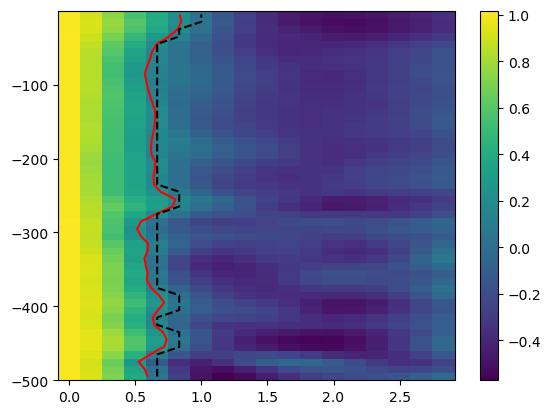

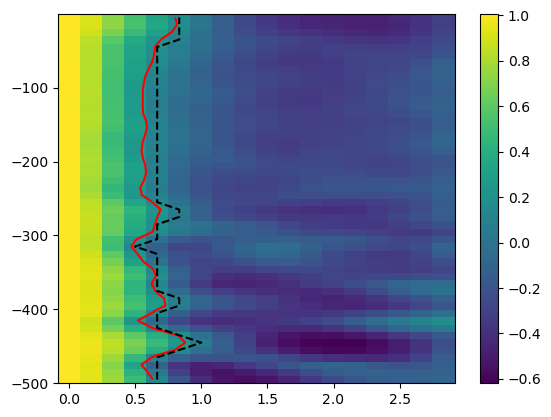

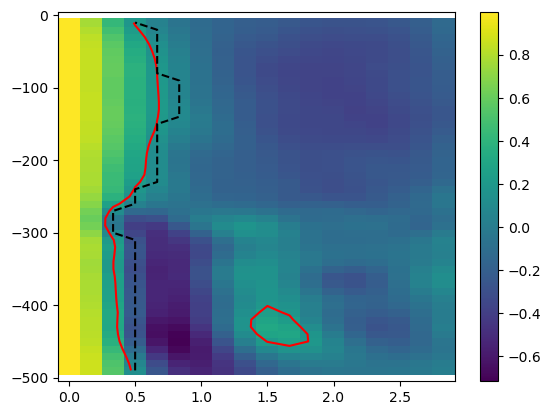

In [24]:
#
plt.figure()
plt.pcolor( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_rho_1d, decor_time.lag_covar_u)
plt.colorbar()
plt.contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_rho_1d, decor_time.lag_covar_u, levels=[0.2], colors='r')
plt.plot(decor_time.decor_t_u/3600, ds.z_rho_1d, 'k--')
#
plt.figure()
plt.pcolor( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_rho_1d, decor_time.lag_covar_v)
plt.colorbar()
plt.contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_rho_1d, decor_time.lag_covar_v, levels=[0.2], colors='r')
plt.plot(decor_time.decor_t_v/3600, ds.z_rho_1d, 'k--')
#
plt.figure()
plt.pcolor( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_w_1d, decor_time.lag_covar_w)
plt.colorbar()
plt.contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/3600, ds.z_w_1d, decor_time.lag_covar_w, levels=[0.2], colors='r')
plt.plot(decor_time.decor_t_w/3600, ds.z_w_1d, 'k--')

### Compute pressure

In [8]:
# Boussinesq pressure, i.e. -\rho_0 g z
dsm["pb"] = -rho0*g*ds.z_w_1d
# hydrostatic pressure -- integrated from surface (hence +rho0*) with bdy cd p_surf=0 ; need to revert s_w in the DataArry accordingly
# contrary to .diff, the boundary conditions for .cumsum is applied to the end product (here pressure), not the variable we integrate (here buoyancy)
p_h = rho0 * grid_z.cumsum( (dsm.bbb*dsm.dz_rho)[::-1, ...], 'z', boundary='fill', fill_value=0.)[::-1, ...]
p_h['s_w'] = p_h.s_w[::-1]
dsm["ph"] = p_h
del p_h
# quasi-nonhydrostatic pressure correction -- integrated from surface (hence +rho0*) with bdy cd p_surf=0 ; need to revert s_w in the DataArry accordingly
p_nh = rho0 * grid_z.cumsum( \
                             ( 0.5 * \
                              ((grid_z.diff(dsm.azz, 'z')/dsm.dz_rho)*(grid_z.diff(dsm.Wm, 'z')/ds.dz_rho)\
                               +dsm.axx * grid_z.interp(grid_xy.diff(grid_xy.diff(dsm.Wm, 'x')/dsm.dx_u, 'x')/dsm.dx_rho, 'z')\
                               +dsm.ayy * grid_z.interp(grid_xy.diff(grid_xy.diff(dsm.Wm, 'y')/dsm.dy_v, 'y')/dsm.dy_rho, 'z')\
                               +grid_z.diff(dsm.azz * grid_z.interp(grid_z.diff(dsm.Wm, 'z')/dsm.dz_rho, 'z', boundary='extrapolate'), 'z')/dsm.dz_rho \
                              )*dsm.dz_rho \
                             )[::-1, ...] \
                              , 'z', boundary='fill', fill_value=0.)[::-1, ...]
p_nh['s_w'] = p_nh.s_w[::-1]
dsm["pnh"]  = p_nh
del p_nh

### Compute velocity Fourrier decomposition

In [9]:
#- dummy spectra for indexing -
iit=-1
kkk=-1
da = xr.Dataset( )
da['u'] = grid_xy.interp(ds.u[iit, kkk, ...],'x')
da = da.rename({'eta_rho': 'y', 'xi_rho': 'x'})
dxy = ds.dx_rho.mean(dim=['eta_rho', 'xi_rho']).data
da = da.assign_coords({"y": ds.y_rho[:, 0].data, "x": ds.x_rho[0, :].data})
u_dft = xrft.fft(da.u, \
                   dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
dkdl=u_dft["freq_x"].spacing*u_dft["freq_y"].spacing
#- initialize dataArray -
dsF = xr.Dataset(
    data_vars=dict(
        uhat=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([dsm.dims['time'], dsm.dims['s_w'], dsm.dims['eta_rho'], dsm.dims['xi_rho']]), dtype='complex')),
        vhat=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([dsm.dims['time'], dsm.dims['s_w'], dsm.dims['eta_rho'], dsm.dims['xi_rho']]), dtype='complex')),
        what=(["time", "s_w", "freq_y", "freq_x"], np.asarray(np.empty([dsm.dims['time'], dsm.dims['s_w'], dsm.dims['eta_rho'], dsm.dims['xi_rho']]), dtype='complex')),
    ),
    coords=dict(
        time=dsm.time,
        s_rho=dsm.s_rho,
        s_w=dsm.s_w,
        freq_y=u_dft.freq_y,
        freq_x=u_dft.freq_x,
    ),
    attrs=dict(description="Fourier modes"),
)
#- Compute -
da = xr.Dataset( )
da['u'] = grid_z.interp(grid_xy.interp(dsm.Upr,'x'),'z', boundary='extrapolate')
da['v'] = grid_z.interp(grid_xy.interp(dsm.Vpr,'y'),'z', boundary='extrapolate')
da['w'] = dsm.Wpr.drop(['x_rho', 'y_rho'])
# remove horizontal mean
da=da-da.mean(dim=['eta_rho', 'xi_rho'])
# rename and turn dimensions in meters (instead of grid index)
da = da.rename({'eta_rho': 'y', 'xi_rho': 'x'})
da = da.assign_coords({"y": dsm.y_rho[:, 0].data, "x": dsm.x_rho[0, :].data})
#- Fourier modes -
dsF["uhat"] = xrft.fft(da.u, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
dsF["vhat"] = xrft.fft(da.v, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
dsF["what"] = xrft.fft(da.w, dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
#
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

---- DONE ----


'2025-06-13 13:45:33'

### Temperature changes, total vertical temp. fluxes, Ito-stockes drift, sto. diffusion

In [10]:
#-- time mean temperature changes --
dsm["dt_T"] =   cff * (ds.temp.isel(time=iit1)-ds.temp.isel(time=iit0)).mean(dim=['eta_rho', 'xi_rho'])
#-- -div of temperature vertical fluxes --
dsm["rhsA"]      = -cff * (grid_z.diff(dsm.wTm,'z') /  dsm.dz_rho_1d ).mean(dim=['eta_rho', 'xi_rho']) * dt
dsm["rhsAm"]     = -cff * (grid_z.diff(dsm.wmTm,'z') / dsm.dz_rho_1d ).mean(dim=['eta_rho', 'xi_rho']) * dt
dsm["rhsA_sgs"]  = -cff * (grid_z.diff(dsm.wTm_sgs,'z') /  dsm.dz_rho_1d ).mean(dim=['eta_rho', 'xi_rho']) * dt
#-- Ito-Stockes drift --
dsm["rhsB"] =   cff * 0.5 * grid_z.diff(dsm.azz , 'z') / dsm.dz_rho_1d * grid_z.interp(dsm.dTdz, 'z') * dt
#-- sto diff --
dsm["rhsD"] =   cff * 0.5 * grid_z.diff(dsm.azz * dsm.dTdz, 'z') / dsm.dz_rho_1d                      * dt
#-- smooth-in-time component of D_t --
dsm["Dt_smooth"] =  -cff * rho0 * 0.5 * grid_z.diff(dsm.azz, 'z') / dsm.dz_rho_1d * dsm.bbb.mean(dim=['eta_rho', 'xi_rho']) * dt

### Compression of Ito-stokes drift

This is actually the contribution of $\mathbb{D}_t\rho_{\textit{BQ}}$, i.e. $P_t=- g (\eta-z)\mathbb{D}_t\rho_{\textit{BQ}}$

See Eq (58) in the manuscript: https://www.overleaf.com/project/676042333f66f6b1bff23ca5

In [11]:
dsm["Pt"] = - cff * \
    ( (dsm.pnh+dsm.ph).mean(dim=['eta_rho', 'xi_rho']) \
     * grid_z.diff( -0.5 * grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d, 'z', boundary='extrapolate')/dsm.dz_w_1d\
    ) * dt
dsm["Pt_h"] = - cff * \
    ( (dsm.ph).mean(dim=['eta_rho', 'xi_rho']) \
     * grid_z.diff( -0.5 * grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d, 'z', boundary='extrapolate')/dsm.dz_w_1d\
    ) * dt
dsm["Pt_nh"] = - cff * \
    ( (dsm.pnh).mean(dim=['eta_rho', 'xi_rho']) \
     * grid_z.diff( -0.5 * grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d, 'z', boundary='extrapolate')/dsm.dz_w_1d\
    ) * dt

### Stochastic advection, 'Resolved' *drift work*, 'Stochastic' *drift work* -- Associated with $\boldsymbol{\sigma} \mathrm{d}\boldsymbol{B}_t$

- Both $A_u$ and $A_t$ are diveded by $Nint$ because both sigdB_z and dz_FT_dBt are function of $\mathrm{d}B_t=Nint\sqrt{\Delta t}$, hence multiplication gives $Nint^2\Delta t = Nint \mathrm{d}t$

In [12]:
for imem in range(nmem):
    print('-- mode', imem, '/', nmem, end='\r')
    # itF is used to select the same time frame than the used to generate sigdBt
    [ds_dBt, itF] = comp_sigdBt(dsF, mu, sigma, tau, dsm)
    # stochastic pressure
    dptsig = comp_dptsig(ds_dBt, dsm.Wm, order='bottom-up')
    #
    #-- C --
    dsm["rhsC"][imem, :] = -cff * \
        grid_z.diff(ds_dBt.sigdB_z * grid_z.interp(dsm.temp, 'z', boundary='extrapolate'), 'z' ).mean(dim=['eta_rho', 'xi_rho']) / ds.dz_rho_1d  
    #-- G ; stochastic component of D_t --
    dsm["Dt_sto"][imem, :] = -cff *             \
        grid_z.diff( (ds_dBt.sigdB_z * (dsm.pnh+dsm.ph) ), 'z').mean(dim=['eta_rho', 'xi_rho'])/ds.dz_rho_1d 
    #-- I ; D_{\sigma} -- at rho-point --
    dsm["Dsig"][imem, :] = -cff * 0.5 * \
        grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d * (grid_z.diff(dptsig, 'z')/dsm.dz_rho_1d).mean(dim=['eta_rho', 'xi_rho'])
    #    
    #
    #-- At --
    #
    #- FT_dBt (at rho-pts) ; include compression effects associated with dptsig*div(u*) -
    dz_FT_dBt = grid_z.diff( \
                             0.5*grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d \
                             *grid_z.diff(dptsig, 'z')/dsm.dz_rho_1d\
                            +grid_z.interp( \
                                           dptsig \
                                          *grid_z.diff(0.5*grid_z.diff(dsm.azz, 'z')/dsm.dz_rho_1d, 'z', boundary='extrapolate')/dsm.dz_w_1d, \
                                          'z'), 
                            'z', boundary='extrapolate')/ds.dz_w  # at rho-pts
    #- At -
    At = cff * ds_dBt.sigdB_z * dz_FT_dBt / Nint
    dsm["At"] += (At.mean(dim=['eta_rho', 'xi_rho']) - dsm.At)/(imem+1)
    #
    # with Fourier
    #
    dz_dptsig = grid_z.diff(dptsig, 'z', boundary='extrapolate')/ds.dz_rho
    dz_dptsig = dz_dptsig.rename({'eta_rho': 'y', 'xi_rho': 'x'})
    dz_dptsig = dz_dptsig.assign_coords({"y": dsm.y_rho[:, 0].data, "x": dsm.x_rho[0, :].data})
    dz_dptsig_hat = xrft.fft(dz_dptsig.drop(['x_rho', 'y_rho']), dim=['x', 'y'], true_phase=True, true_amplitude=True).compute()
    tmp = cff * ( ( dsF.what.isel(time=itF).conjugate() \
             *grid_z.diff( 0.5*grid_z.diff(-dsm.azz, 'z')/dsm.dz_rho_1d * dz_dptsig_hat, \
                          'z', boundary='extrapolate' )/dsm.dz_w_1d \
            ).real ).sum(dim=['freq_y', 'freq_x']) * dkdl / Area * dt
    dsm["At_F"] += (tmp - dsm.At_F)/(imem+1)
    #
    #-- Au ; at w-point --
    #
    Au = - cff * 0.5 / rho0 * \
        ( \
         ( grid_xy.interp( (grid_xy.diff(dptsig, 'x')/ds.dx_u)**2, 'x') \
          +grid_xy.interp( (grid_xy.diff(dptsig, 'y')/ds.dy_v)**2, 'y') \
          +grid_z.interp(  (grid_z.diff( dptsig, 'z')/ds.dz_rho)**2, 'z', boundary='extrapolate') \
         ) \
        ) / Nint
    dsm["Au"] += (Au.mean(dim=['eta_rho', 'xi_rho']).data - dsm.Au)/(imem+1)
    #
    #- Psig -
    #
    Psig = - cff * dptsig * grid_z.diff(grid_z.diff(-0.5*dsm.azz, 'z')/dsm.dz_rho_1d, 'z', boundary='extrapolate')/dsm.dz_w_1d
    dsm["Psig"] += (Psig.mean(dim=['eta_rho', 'xi_rho']).data - dsm.Psig)/(imem+1)
#
print('---- DONE ----')
datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

---- DONE ----500


'2025-06-13 13:48:14'

### Figures

internal


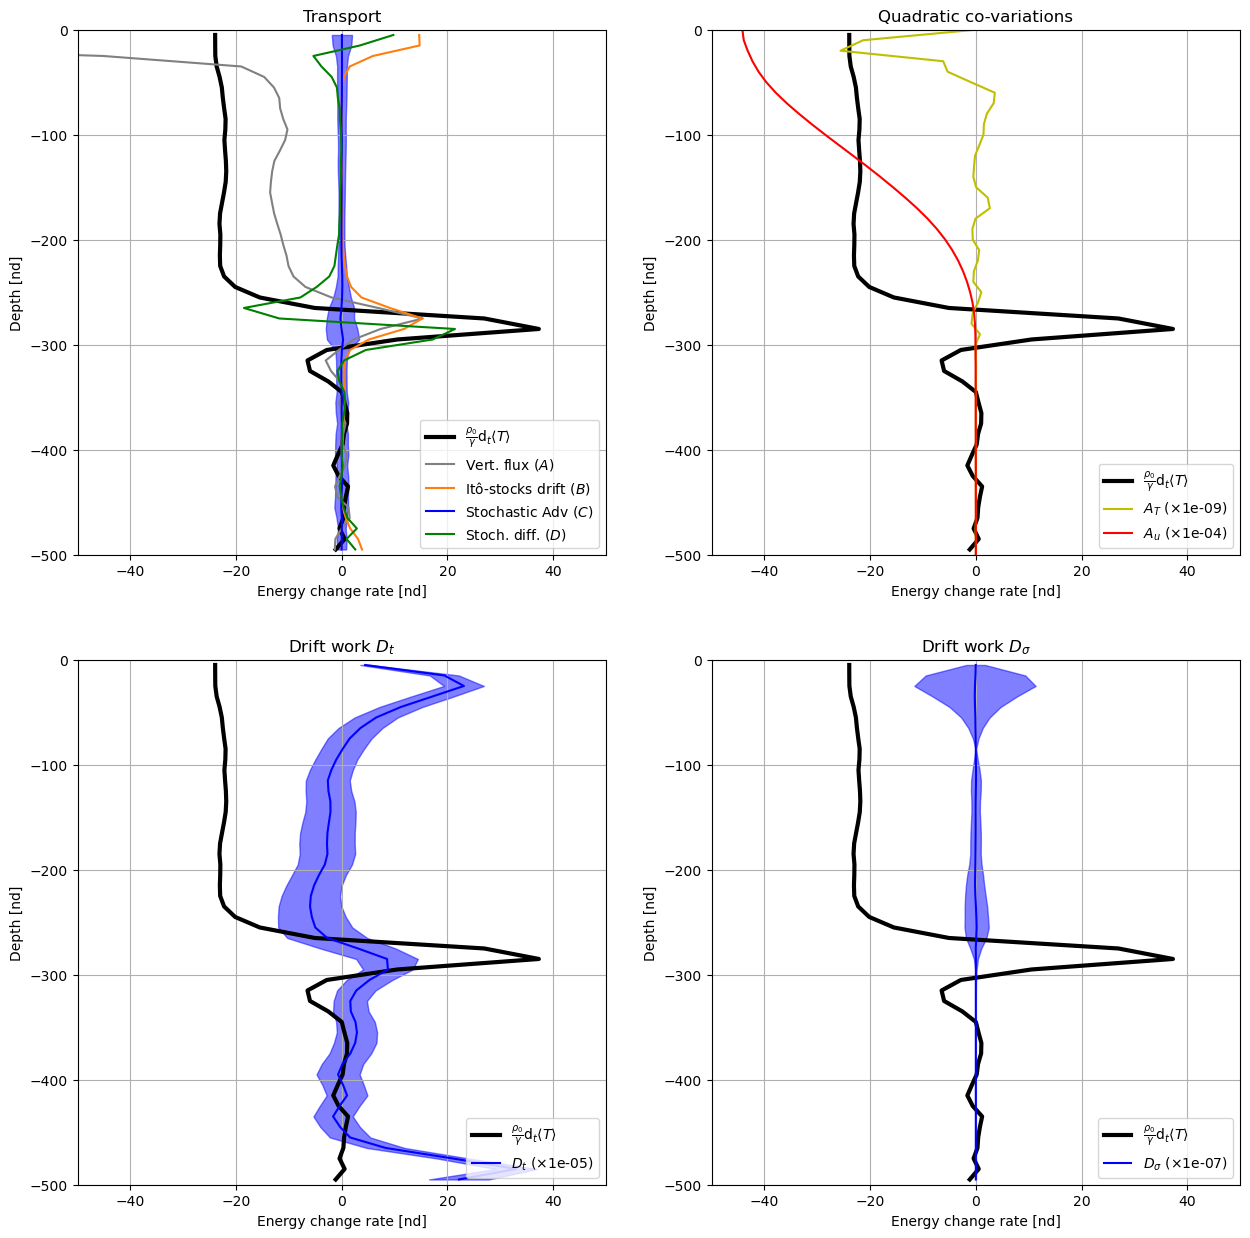

In [45]:
saveF = True
#
nrj='internal'    # internal or potential
if nrj == 'internal':
    print('internal')
    cff_nrj = rho0*Cv
    scaleF_At  = 1e9
    scaleF_Au = 1e4
    scaleF_Dt  = 1e5
    scaleF_Dsig  = 1e7
    xxlim = 5e1
    llab0 = str(r"$\frac{\rho_0}{\gamma} \mathrm{d}_t \left< T \right>$")
elif nrj == 'potential':
    print('potential')
    cff_nrj = rho0*g*(dsm.z_rho_1d)*alphaT
    scaleF_At  = 1e5
    scaleF_Au = 1e0
    scaleF_Dt  = 1e1
    scaleF_Dsig  = 1e3
    xxlim = 6e-3
    llab0 = str(r"$\rho_0 g \beta_T z ~ \mathrm{d}_t \left< T \right>$")
#
fig, ax = plt.subplots(figsize=(15,15), nrows=2, ncols=2)
for iii in range(2):
    for jjj in range(2):
        #ax[iii, jjj].plot(cff_nrj*dsm.rhsA, dsm.z_rho_1d, label=r"$\left< -\partial_z \overline{w'T'} \mathrm{d}t \right>$", color='k', lw=3, alpha=0.5)
        ax[iii, jjj].plot(cff_nrj*dsm.dt_T, dsm.z_rho_1d, label=llab0, color='k', lw=3, alpha=1.0)
#
# ax[0, 0].plot(cff_nrj*dsm.dt_T, dsm.z_rho_1d, label=r'$<T>_{f}-<T>_{i}$', color='k', lw=3)
# ax[0, 0].plot(cff_nrj*( dsm.rhsA+dsm.rhsA_sgs ), dsm.z_rho_1d, label=r"$\left<-\partial_z (\overline{w'T'}+\overline{w'T'}_{sgs}) \mathrm{d}t \right>$", color='green')
# ax[0, 0].set(title='Reference', xlabel='[Adim]', ylabel='Depth [m]')
# #
# ax[0, 1].plot(decor_time.decor_t_u/60, ds.z_rho_1d, color='green', label='u')
# ax[0, 1].plot(decor_time.decor_t_v/60, ds.z_rho_1d, color='b', label='u')
# ax[0, 1].plot(decor_time.decor_t_w/60, ds.z_w_1d, color='r', label='u')
# # ax[0, 1].contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/60, ds.z_rho_1d, decor_time.lag_covar_u, levels=[0.2], colors='green')
# # ax[0, 1].contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/60, ds.z_rho_1d, decor_time.lag_covar_v, levels=[0.2], colors='b')
# # ax[0, 1].contour( (ds.time.isel(time=slice(iit0, iit1))-ds.time.isel(time=iit0))/60, ds.z_w_1d, decor_time.lag_covar_w, levels=[0.2], colors='r')
# ax[0, 1].set(title='Decorrelation timescale', xlabel='Time [minutes]', xlim=[0, 75])
# #
# ax[0, 2].plot(dsm.axx, dsm.z_rho_1d, color='green', label=r'$\left< \overline{a_{xx}} \right>$', alpha=0.4)
# ax[0, 2].plot(dsm.ayy, dsm.z_rho_1d, color='b'    , label=r'$\left< \overline{a_{yy}} \right>$', alpha=0.4)
# ax[0, 2].plot(dsm.azz, dsm.z_w_1d  , color='r'    , label=r'$\left< \overline{a_{zz}} \right>$')
# ax[0, 2].set(title='Noise variance', xlabel='[Adim]')
#
ax[0, 0].plot(cff_nrj * (dsm.rhsAm+dsm.rhsA_sgs), dsm.z_rho_1d, color='gray', label=r"Vert. flux ($A$)")
ax[0, 0].plot(cff_nrj*dsm.rhsB, dsm.z_rho_1d, label=r"Itô-stocks drift ($B$)", color='C1')
ax[0, 0].plot(cff_nrj*dsm.rhsC.mean(dim='memb') , dsm.z_rho_1d, 'b', label=r"Stochastic Adv ($C$)")
ax[0, 0].fill_betweenx(dsm.z_rho_1d, cff_nrj*(dsm.rhsC.mean(dim='memb')-dsm.rhsC.std(dim='memb', ddof=1)), \
                       cff_nrj*(dsm.rhsC.mean(dim='memb')+dsm.rhsC.std(dim='memb', ddof=1)), alpha=0.5, color='b')
ax[0, 0].plot(cff_nrj*dsm.rhsD, dsm.z_rho_1d, label=r"Stoch. diff. ($D$)", color='green')
#ax[0, 0].plot(cff_nrj*(dsm.rhsD+dsm.rhsB), dsm.z_rho_1d, label='1/+2/', color='red', lw=3)
ax[0, 0].set(title='Transport')
#
ax[0, 1].plot(dsm.At*scaleF_At, dsm.z_w_1d, color='y', label=str(r"$A_T$ ($\times$%.00e)" % (1/scaleF_At)) )
#ax[0, 1].plot(dsm.At_F*scaleF_AtF, dsm.z_w_1d, color='blue', ls='--', label=str(r"$A_T$ ($\times$%.00e) -- with Fourrier" % (1/scaleF_AtF)) )
ax[0, 1].plot(dsm.Au*scaleF_Au, dsm.z_w_1d, color='r',  label=str(r"$A_u$ ($\times$%.00e)" % (1/scaleF_Au)) )
ax[0, 1].set(title='Quadratic co-variations')
#
# ax[0, 2].plot(dsm.Pt*scaleF_Pt, dsm.z_w_1d, color='blue', label=str(r"$P_{t}$ ($\times$%.00e)" % (1/scaleF_Pt)) )
# ax[0, 2].plot(dsm.Psig*scaleF_Psig, dsm.z_w_1d, color='orange', label=str(r"$P_{\sigma}$ ($\times$%.00e)" % (1/scaleF_Psig)) )
# ax[0, 2].set(title='Compression terms')
#
# ax[1, 0].plot(cff_nrj*dsm.rhsC.mean(dim='memb'), dsm.z_rho_1d, 'r', \
#               label=r"$-\frac{\rho_0}{\gamma} <\partial_z \overline{\sigma \mathrm{d}B_t^{(z)}T}>$")
# ax[1, 0].fill_betweenx(dsm.z_rho_1d, cff_nrj*(dsm.rhsC.mean(dim='memb')-dsm.rhsC.std(dim='memb', ddof=1)), \
#                        cff_nrj*(dsm.rhsC.mean(dim='memb')+dsm.rhsC.std(dim='memb', ddof=1)), alpha=0.5, color='r', label=r'std')
# ax[1, 0].set(title='Stochastic advection')
#
ax[1, 0].plot(dsm.Dt_smooth*scaleF_Dt, dsm.z_rho_1d, 'b', label=str(r'$D_t$ ($\times$%.0e)' % (1/scaleF_Dt)))
ax[1, 0].fill_betweenx(dsm.z_rho_1d, (dsm.Dt_smooth-dsm.Dt_sto.std(dim='memb', ddof=1))*scaleF_Dt, \
                       (dsm.Dt_smooth+dsm.Dt_sto.std(dim='memb', ddof=1))*scaleF_Dt, \
                       alpha=0.5, color='b')
ax[1, 0].set(title=r'Drift work $D_t$')
#
ax[1, 1].plot(dsm.Dsig.mean(dim='memb')*scaleF_Dsig, dsm.z_rho_1d, 'b', label=str(r'$D_{\sigma}$ ($\times$%.0e)' % (1/scaleF_Dsig)))
ax[1, 1].fill_betweenx(dsm.z_rho_1d, (dsm.Dsig.mean(dim='memb')-dsm.Dsig.std(dim='memb', ddof=1))*scaleF_Dsig, \
                       (dsm.Dsig.mean(dim='memb')+dsm.Dsig.std(dim='memb', ddof=1))*scaleF_Dsig, \
                       alpha=0.5, color='b')
ax[1, 1].set(title=r'Drift work $D_{\sigma}$')
# #
ip=0
for iii in range(2):
    for jjj in range(2):
        ax[iii, jjj].set(ylim=[-500, 0], xlim=[-xxlim, +xxlim], ylabel='Depth [nd]', xlabel='Energy change rate [nd]')
        ax[iii, jjj].legend(loc='lower right')
        ax[iii, jjj].grid()
#
if saveF:
    figN="T_sto_bgt_time_filtered_"+nrj+"_energy_full"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

potential


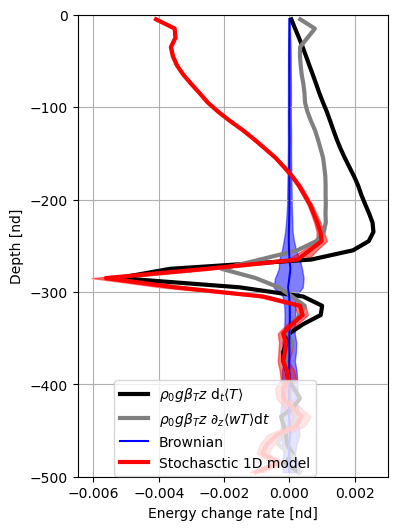

In [43]:
# \Deltat e = -10.544
# \Delta pe = +5.831 e-4 -- in agreement with nrj time series estimates
saveF = True
#
nrj='potential'    # internal or potential
llab2 = str(r"Stochasctic 1D model")
llab3 = str(r"Brownian")
if nrj == 'internal':
    print('internal')
    cff_nrj = rho0*Cv
    #
    sto = cff_nrj * dsm.rhsC
    smoothinT = cff_nrj * (dsm.rhsAm+dsm.rhsA_sgs + dsm.rhsD+dsm.rhsB)
    wT = cff_nrj * (dsm.rhsAm+dsm.rhsA_sgs)
    #
    llab0 = str(r"$\frac{\rho_0}{\gamma} \mathrm{d}_t \left< T \right>$")
    llab1 = str(r"$\frac{\rho_0}{\gamma} \partial_z \left< wT \right> \mathrm{d}t $")
elif nrj == 'potential':
    print('potential')
    cff_nrj = rho0*g*(dsm.z_rho_1d)*alphaT
    #
    sto = cff_nrj * dsm.rhsC + dsm.Dt_sto + dsm.Dsig
    smoothinT = cff_nrj * (dsm.rhsAm+dsm.rhsA_sgs + dsm.rhsD+dsm.rhsB) + grid_z.interp(dsm.Au, 'z') + dsm.Dt_smooth
    wT = cff_nrj * (dsm.rhsAm+dsm.rhsA_sgs)
#    smoothinT = grid_z.interp(dsm.Au, 'z')
    #
    llab0 = str(r"$\rho_0 g \beta_T z ~ \mathrm{d}_t \left< T \right>$")
    llab1 = str(r"$\rho_0 g \beta_T z ~ \partial_z \left< wT \right> \mathrm{d}t$")
#
fig, ax = plt.subplots(figsize=(4,6), nrows=1, ncols=1)
#- ref -
ax.plot(cff_nrj * dsm.dt_T, dsm.z_rho_1d, color='k', lw=3, label=llab0)
ax.plot( wT       , dsm.z_rho_1d,         color='gray',lw=3, label=llab1)
#- stochastic -
ax.plot(sto.mean(dim='memb'), dsm.z_rho_1d, 'b', label=llab3)
ax.fill_betweenx(dsm.z_rho_1d, (sto.mean(dim='memb')-sto.std(dim='memb', ddof=1)), (sto.mean(dim='memb')+sto.std(dim='memb', ddof=1)), alpha=0.5, color='b')
# ax.fill_betweenx(dsm.z_rho_1d, (smoothinT-sto.std(dim='memb', ddof=1)), (smoothinT+sto.std(dim='memb', ddof=1)), alpha=0.5, color='b', label=llab3)
#- smooth in time components -
ax.plot( smoothinT, dsm.z_rho_1d, lw=3, color='r', label=llab2)
ax.fill_betweenx(dsm.z_rho_1d, (smoothinT-sto.std(dim='memb', ddof=1)), (smoothinT+sto.std(dim='memb', ddof=1)), alpha=0.5, color='r')
#
ax.grid(); 
fig.legend(loc='lower left', bbox_to_anchor=(0.2, 0.1, 1., 1.))
ax.set(ylim=[-500, 0], ylabel='Depth [nd]', xlabel='Energy change rate [nd]')
if nrj == 'internal':
    ax.set(xlim=[-50, 50])
# elif nrj == 'potential':
#     ax.set(xlim=[-0.01, 0.01])
#
if saveF:
    figN = "summary_T_sto_bgt_time_filtered_"+nrj+"_energy"
    fig.savefig(str("%s/%s.png" % (dir_fig, figN)), bbox_inches='tight')
    fig.savefig(str("%s/%s.pdf" % (dir_fig, figN)), bbox_inches='tight')

# Some other stuff

- both bottom-up and top-down dptsig provide the same results once horizontally averaged, if expressed at w-point (small differences when expressed at rho-point), i.e. both surface and bottom bdy =0 are satisfied -> the noise does not 

In [ ]:
############
# bottom up integration
def comp_dptsig_bu(ds_sig, www):
    #
    dptsig = rho0 * grid_z.cumsum( \
                                  (( \
                                    grid_xy.interp(grid_xy.diff(ds_sig.sigdB_x*www, 'x')/ds.dx_u, 'x') \
                                   +grid_xy.interp(grid_xy.diff(ds_sig.sigdB_y*www, 'y')/ds.dy_v, 'y') \
                                   +grid_z.interp(grid_z.diff(ds_sig.sigdB_z*www, 'z')/ds.dz_rho, 'z', boundary='extrapolate') \
                                   )*ds.dz_w),\
                                  'z')
    #
    return dptsig

def comp_dptsig_bu2(ds_sig, www):
    #
    dptsig = rho0 * grid_z.cumsum( \
                                  (( \
                                    grid_z.interp( \
                                                  grid_xy.interp(grid_xy.diff(ds_sig.sigdB_x*www, 'x')/ds.dx_u, 'x') \
                                                 +grid_xy.interp(grid_xy.diff(ds_sig.sigdB_y*www, 'y')/ds.dy_v, 'y'), \
                                                  'z')
                                   +grid_z.diff(ds_sig.sigdB_z*www, 'z')/ds.dz_rho \
                                   )*ds.dz_rho),\
                                  'z', boundary='fill', fill_value=0.)
    #
    return dptsig

############
# top down integration
def comp_dptsig_td(ds_sig, www):
    #
    dptsig = -rho0 * grid_z.cumsum( \
                                  (( \
                                    grid_xy.interp(grid_xy.diff(ds_sig.sigdB_x*www, 'x')/ds.dx_u, 'x') \
                                   +grid_xy.interp(grid_xy.diff(ds_sig.sigdB_y*www, 'y')/ds.dy_v, 'y') \
                                   +grid_z.interp(grid_z.diff(ds_sig.sigdB_z*www, 'z')/ds.dz_rho, 'z', boundary='extrapolate') \
                                   )*ds.dz_w)[::-1, ...],\
                                  'z')[::-1, ...]
    #
    dptsig['s_rho'] = dptsig.s_rho[::-1]
    return dptsig
